<a href="https://colab.research.google.com/github/Tolemy21/MAE-598-DO/blob/main/MAE_598_Project_1_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4. Grading

* (20%) **Documentation of the problem formulation**: Clearly describe the objective function, the variables, the constraints (including the dynamical systems involved), and the assumptions involved in formulating the problem.

* (30%) **Programming**: Please push you code to your github repo or a deepnote notebook. Please comment your code so that it is useful to you in the future.

* (30%) **Analysis of the results**: Please explain clearly and in details all issues you encountered and lessons you learned in solving your problem, including incorrect problem formulations, hyperparameter tuning (e.g., for the optimization algorithm), and coding issues (e.g., related to tensor operations).

* (20%) **Visualization**: Once you find a converged solution, please do your best to visualize the final results in video and other necessary formats so that other people can easily understand what you achieved.

# MAE 598 Design Optimization: Project 1: Bicycle Model

By Tolemy Nibi


# Project 1: Gradient-based Algorithms and Differentiable Programming

## 1. Introduction
Consider a bicycle model where the bicycle state $\textbf{x}(t)$ is represented by its coordinates $x(t)$ and $y(t)$, and orientation $\theta(t)$, i.e., $\textbf{x}(t) = [x(t), y(t), \theta(t)]^T$, where $t$ specifies time. The control input $\textbf{u}(t)$ of the bicycle includes linear velocity $v(t)$ and angular velocity $\omega(t)$.


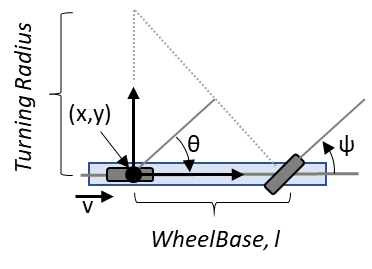


## Variables
\begin{align*}
& x \text{ Global vehicle x-position in meters} \\
& y \text{ Global vehicle y-position in meters} \\
& θ \text{ Global vehicle heading in radians} \\
& l \text{ Wheel base, in meters}\\
& ψ \text{ Vehicle steering angle in radians} \\
& v \text{ Vehicle speed in meters/s} \\
& ω \text{ Vehicle heading angular velocity in radians/s}\\
& \text{} \\
& \text{Assumptions} \\
& \text{#1 No Slip Condition} \\
& \text{#2 No Sideslip - allows you to simplify a four wheeled vehicle (like a car or tractor) into a two wheeled model (Bicycle)} \\
& \text{#3 Ackermann Steering} \\
& \text{#4 Rigid Body - no deformations or flexibility}\\
& \text{#5 2D Planar Motion - no gravity} \\
& \text{#6 No spring or damper} \\
& \text{#7 Negligible Friction Losses} \\
& \text{#8 Rolling Without Tipping or Slipping} \\
& \text{} \\
& \text{Constraints} \\
& \text{#1 θ cannot be greater than |1| rad. => -57.296 or 57.296 degrees (-1, 1) radians} \\
& \text{#2 Obstacle avoidance of a rocket. In 2D looks like a disk.} \\
& \end{align*}


## State Space

$$
\left[\begin{matrix} \dot{x}\\ \dot{y} \\ \dot{\theta} \\\end{matrix}\right]\ =\ \left[\begin{matrix} cos{\theta} & 0\\ sin{\theta} & 0 \\ \frac{tan(\psi)}{l} & 1 \\\end{matrix}\right]\left[\begin{matrix}v \\ \omega \\\end{matrix}\right]
$$


The discrete-time dynamics are as follows:

$$
\begin{aligned}
& x(t+1) = x(t) + \dot{x}(t) \Delta t = x(t) + v * cos(\theta)\Delta t, \\
& y(t+1) = y(t) + \dot{y}(t) \Delta t = y(t) + v * sin(\theta)\Delta t, \\
& \theta(t+1) = \theta(t) + \dot{\theta}(t) \Delta t = \theta(t) + \omega \Delta t,
& \end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be

$$
\textbf{u}(t) = [v(t), \omega(t)] = \pi_{w}(\textbf{x}(t))
$$

where $\pi_{w}(\cdot)$ is a neural network with parameters $w$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(\textbf{x}(t),\textbf{u}(t))$. In this example, we will simply set $l(\textbf{x}(t),\textbf{u}(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(\textbf{x}(T),\textbf{u}(T)) = ||\textbf{x}(T)||^2$.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{w} \quad & \quad ||x(T)||^2 \\
& x(t+1) = x(t) + v * cos(\theta)\Delta t, \\
& y(t+1) = y(t) + v * sin(\theta)\Delta t, \\
& \theta(t+1) = \theta(t) + \omega * \Delta t, \\
\quad & \quad \text{u}(t) = \pi_{w}(\textbf{x}(t)), ~\forall t=1,...,T-1
\end{aligned}
$$


The optimization problem when adding the rocket obstacle

$$
\begin{aligned}
\min_{w} \quad & \quad ||x(T)||^2 + \frac{ ∑ \exp(r - (center - trajectory . points)) }{T}  \\
& x(t+1) = x(t) + v * cos(\theta)\Delta t, \\
& y(t+1) = y(t) + v * sin(\theta)\Delta t, \\
& \theta(t+1) = \theta(t) + \omega * \Delta t, \\
\quad & \quad \text{u}(t) = \pi_{w}(\textbf{x}(t)), ~\forall t=1,...,T-1
\end{aligned}
$$


While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $\textbf{x}(T-1)$ and $\textbf{u}(T-1)$, where $\textbf{x}(T-1)$ as a function of $\textbf{x}(T-2)$ and $\textbf{u}(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $w$.

In the following, we code the forward pass of the loss using [PyTorch](https://pytorch.org/), which then automatically computes the gradient $\nabla_{w} l(\textbf{x}(T),\textbf{u}(T))$.

In [ ]:
# Code updated from former student: https://github.com/siddahant/DESOPT/blob/RocketLanding/Rocket_Landing_Optimization.ipynb

# overhead
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# !pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')

!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

# !pip install cvxpy==1.4.1
# !pip install cvxpylayers==0.1.6


In [ ]:
# environment parameters

FRAME_TIME = 0.1  # time interval

# Adjustable parameters
# Alpha, Beta, Gamma
alpha = 1
beta = 1
gamma = 1

Here we set up the dynamical model in Pytorch. The dynamics is written as the forward pass of a neural network (``nn.Module``) so that it becomes a part of a differentiable computational graph. Note: This is the part that requires a lot of patience and care!

Some explanation:

* ``state_tensor`` is $ x_{tensor} = [\cos(\theta), \sin(\theta),  0]^T$
* ``state_theta`` is $\theta_{state} = [\sin(\theta), \cos(\theta),  0]^T$
* ``velocity_tensor`` is $ v_{tensor} = [v, v, 0]^T$

* ``omega_tensor`` is $ \omega_{tensor} =[0, 0, \omega]^T$

* ``Delta_state`` is $ \Delta_{state} = [v*cos(\theta)\Delta t, v*sin(\theta)\Delta t, \omega\Delta t]^T$

* ``Delta_state_Final`` = $ [\alpha*v*cos(\theta) *\Delta t, \beta*v*cos(\theta) *\Delta t, \gamma*\omega *\Delta t]^T $


## Updating States
* the velocity and orientation are then updated by ``state = state + Delta_state_Final``


In [ ]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Velocity
        action[1] = Omega

        state[0] = x
        state[1] = y
        state[2] = theta

        """
        # Parameters
        L = 1;

        FRAME_TIME = 0.1  # delta_time_step

        state_tensor = torch.zeros((1, 3))
        state_tensor[0, 0] = torch.cos(state[0, 2]) # cos(\theta)
        state_tensor[0, 1] = torch.sin(state[0, 2]) # sin(\theta)
        state_tensor[0, 2] = 0                      # 0


        state_theta = torch.zeros((1, 3))
        state_theta[0, 0] = torch.sin(state[0, 2]) # sin(\theta)
        state_theta[0, 1] = torch.cos(state[0, 2]) # cos(\theta)
        state_theta[0, 2] = 0                      # 0

        velocity_tensor = torch.mul(torch.tensor([1, 1, 0]), action[0, 0].reshape(-1, 1) ) # [v, v, 0]
        omega_tensor = torch.mul(torch.tensor([0, 0, 1]), action[0, 1].reshape(-1, 1) )    # [0, 0, \omega]

        inter_mat = torch.mul(state_tensor, velocity_tensor) # [v*cos(\theta), v*cos(\theta), 0]

        Delta_state = FRAME_TIME * (inter_mat + omega_tensor) # [v*cos(\theta) *\Delta t, v*cos(\theta) *\Delta t, \omega *\Delta t]

        Parameters_model = torch.zeros((1, 3))
        Parameters_model[0, 0] = alpha   # alpha
        Parameters_model[0, 1] = beta    # beta
        Parameters_model[0, 2] = gamma   # gamma

        Delta_state_Final = torch.mul(Delta_state, Parameters_model) # [alpha*v*cos(\theta) *\Delta t, beta*v*cos(\theta) *\Delta t, gamma*\omega *\Delta t]

        # state = state + Delta_state
        state = state + Delta_state_Final

        return state

Now we define a controller using another neural network. The network takes in the **3 state variables** and **outputs 2 action variables**. The one we use here has two hidden layers with ``Tanh`` activation. The output layer uses ``Sigmoid`` activation so that the two output values are within 0 to 1. We then linearly transform the outputs so that the first variable (thrust) is ranged in 0 to 2, and the second variable (angular velocity) is ranged in -1 to 1 (so that the rocket can tilt in both directions).

In [ ]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden:
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        # action = (action - torch.tensor([0.5, 0.5]))*2
        action = torch.mul((action - torch.tensor( [0.5, 0.5] )),torch.tensor([4,2]))
        return action


Now with the dynamical model and the controller, we can simulate the landing (or not landing) of the rocket. We set the initial state to $[0, 4, 0, 0, 0]$ (initial altitude = 4). Using ``action = self.controller(state)`` we get an action from the initial state, and using ``state = self.dynamics(state, action)`` we get the next state from the action. This is iterated for ``T`` steps, at the end of which we compute the ``error`` to be minimized with respect to the controller weights.

Some comments:
* The controller optimized this way will be specific to the given initial state. It is, however, more reasonable to design a controller that works for a range of initial states. This can be approximately done by optimizing the errors for a batch of initial states rather than one. Modern programming language such as Pytorch, Tensorlow, JAX, Julia all support parallel tensor computation and thus can easily extend our current implementation to the batch mode.
* A more formal way of computing a feedback controller for a set of initial states would be to solve Hamilton-Jacobi-Bellman equation, which can be formulated as a different optimization problem. When dynamics is unknown or partially known, we usually resort to model-based or model-free reinforcement learning.
* It is often necessary to fine-tune the weights on each loss terms, e.g., if landing with zero velocity is critical, then one might need to put high weights on $\dot{y}(t)$ to force it to 0.

In [ ]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # state = [ [3., 4., math.pi/4] ] # x, y, theta
        state = [ [5., 8., 0] ] # x, y, theta

        return torch.tensor(state, requires_grad=False).float()

    def error(self,state):
      radius = 1
      x1=torch.tensor([tensor[:,0] for tensor in self.state_trajectory])
      y1=torch.tensor([tensor[:,1] for tensor in self.state_trajectory])
      return torch.mean((state-torch.tensor([[ -2., 0., 0. ]]))**2) + torch.tensor(50)*torch.mean(torch.exp(torch.tensor(radius)-torch.sqrt(   (torch.tensor(3)-y1)**2  + (torch.tensor(3)-x1)**2 ) ))


Now that we have built the computational graph for the error to be minimized, we can compute the gradient of the error with respect to the controller weights and apply gradient-based algorithms to minimize the error. The particular algorithm we adopt here is ``L-BFGS``, which is a quasi-Newton type of algorithm that uses a limited memory of past gradients to approximate the current Hessian (think about a first-order Taylor's expansion on the gradient itself). The algorithm also guarantees a positive definite Hessian approximation, allowing it to be applicable to non-convex problems.

Some comments:
* Gradient descent can also be applied here. Newton's method cannot since the problem is not convex.
* Here I use a fixed step size (or learning rate) ``lr = 0.01``. Adaptive step size or line search might help to improve the search efficiency.

In [ ]:
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects

    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()

        plt.plot(list(range(epochs)), l)
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)

    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        theta = data[:, 2]

        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 3, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')
        circle = patches.Circle((3, 3), radius=1, edgecolor='r', facecolor='none') # The rocket that the model should to avoid
        ax[0].add_patch(circle)

        ax[1].plot(frame, theta, c = 'g', label = "theta")
        ax[1].set_xlabel("Time interval")
        ax[1].set_ylabel(r"$\theta$")
        ax[1].legend(frameon=0)
        ax[1].set(title=f'Theta plot at {self.epoch}')

        ax[2].plot(frame, thrust, c = 'y', label = "velocity")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Velocity")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Velocity plot at {self.epoch}')
        plt.show()

    def animation(self, epochs):
        length = 0.02         # m
        width = 0.30          # m

        v_exhaust = 1

        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (4,7), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust line

        plt.tight_layout()
        plt.grid()


        ax1.set_xlim(-10, 10)
        ax1.set_ylim(-10, 10)

        ax1.set_xlabel('x (m)')
        ax1.set_ylabel('y (m)')
        ax1.set_title('Bicycle Moving to its Final State')

        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit
        ax1.plot(-2,0,marker="o", markersize=6,markeredgecolor="red")
        circle = patches.Circle((3, 3), radius=1, edgecolor='orange', facecolor='tomato')
        ax1.add_patch(circle)

        def update(i):
            rocket_theta = x_t[i, 2]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            # thrust_mag = u_t[i, 0]
            # thrust_angle = -u_t[i, 1]

            # flame_length = (thrust_mag) * (0.4/v_exhaust)
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.sin(rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(rocket_theta)]

            # ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 1000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps = 60)
        anim.save("Bicycle_movement_1.gif", writer=writer)


Now we have almost everything set up. We will just need to put in some hyperparameters and let the code run!

[1] loss: 27.820


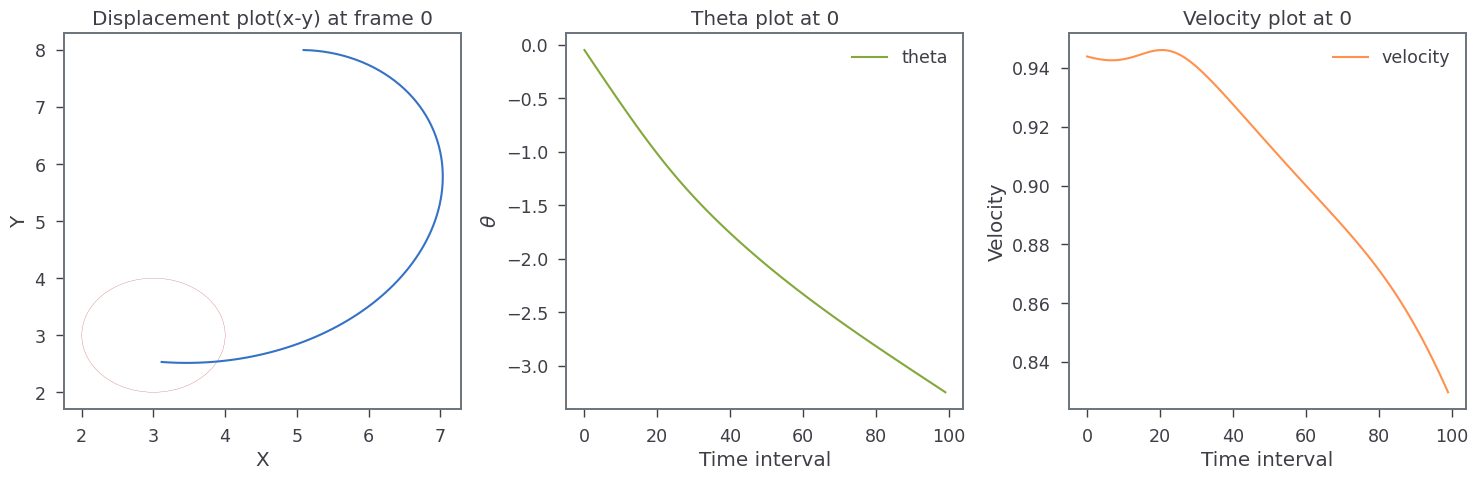

[2] loss: 18.489


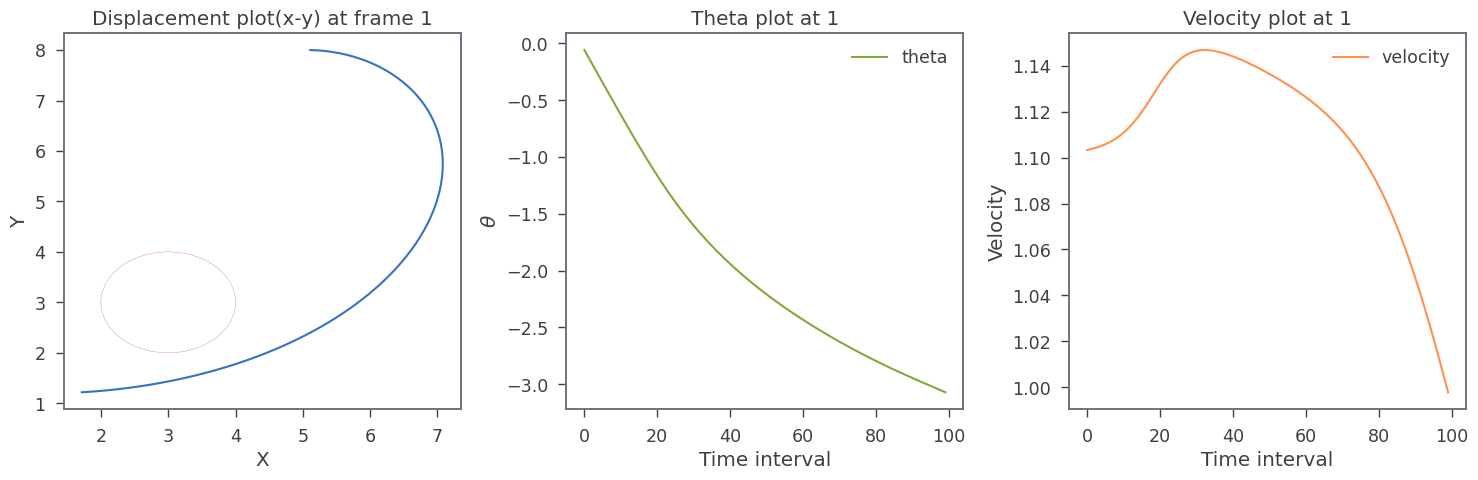

[3] loss: 15.153


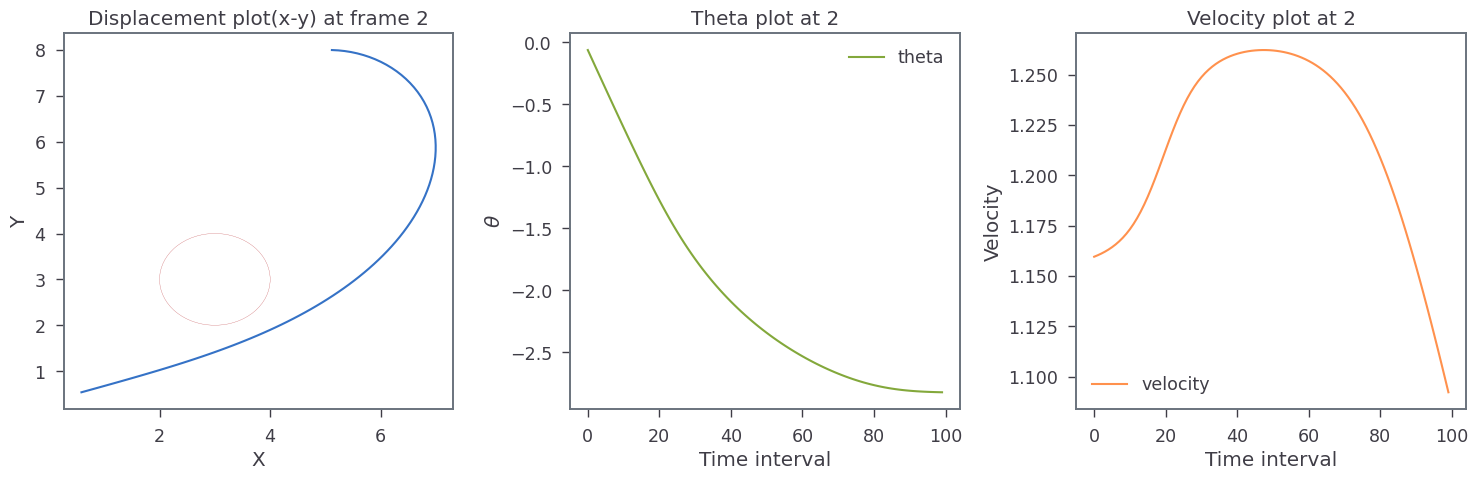

[4] loss: 15.244


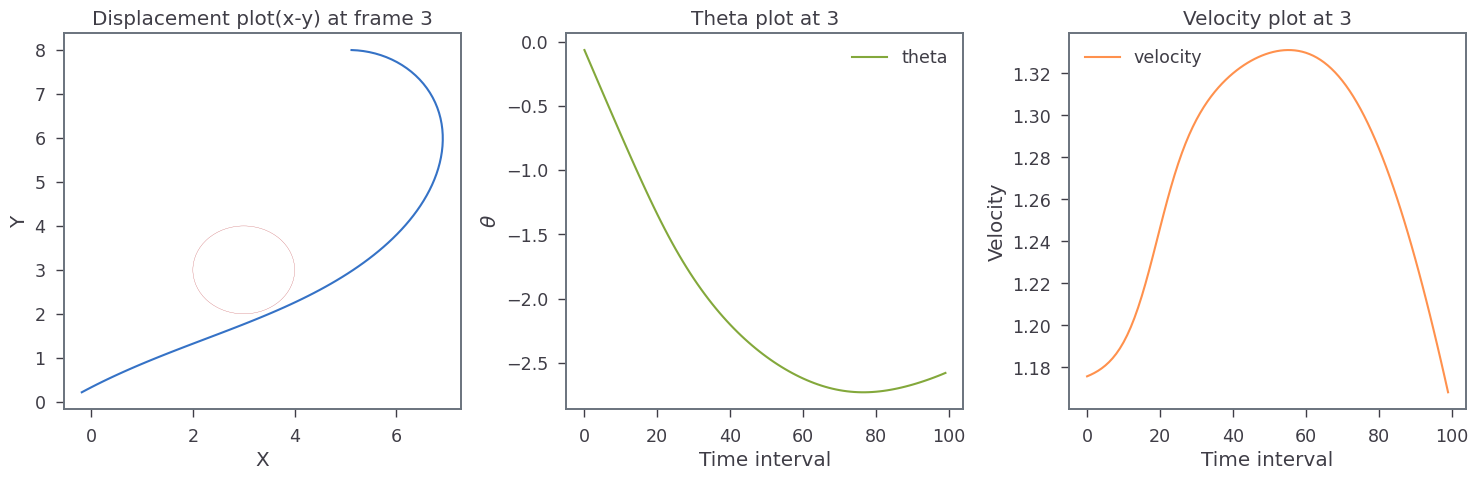

[5] loss: 16.910


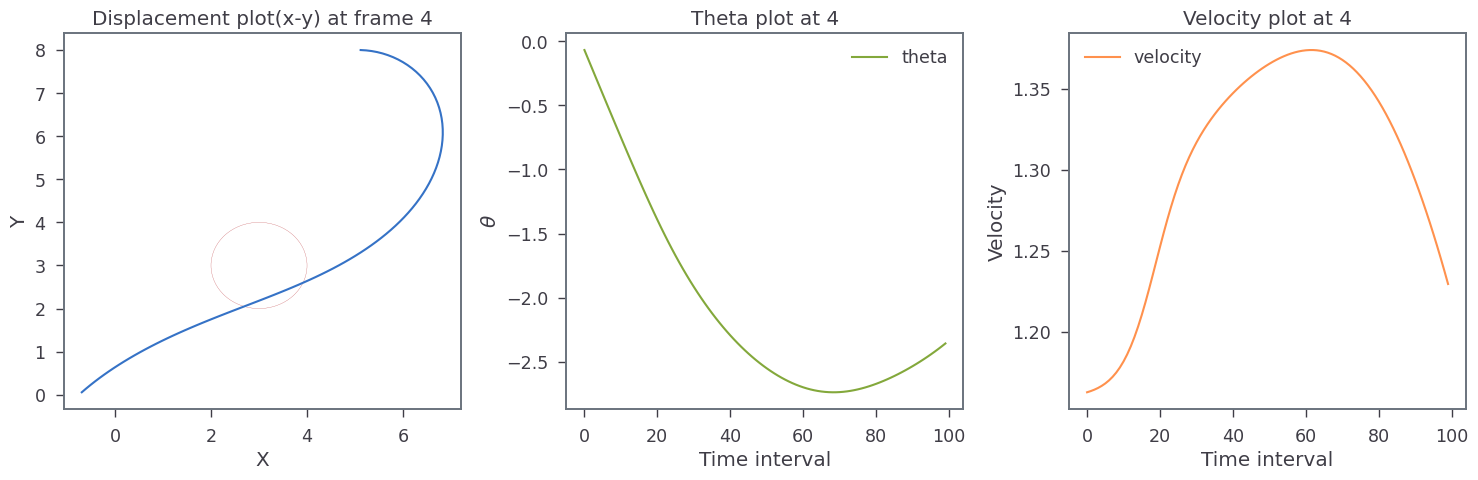

[6] loss: 19.798


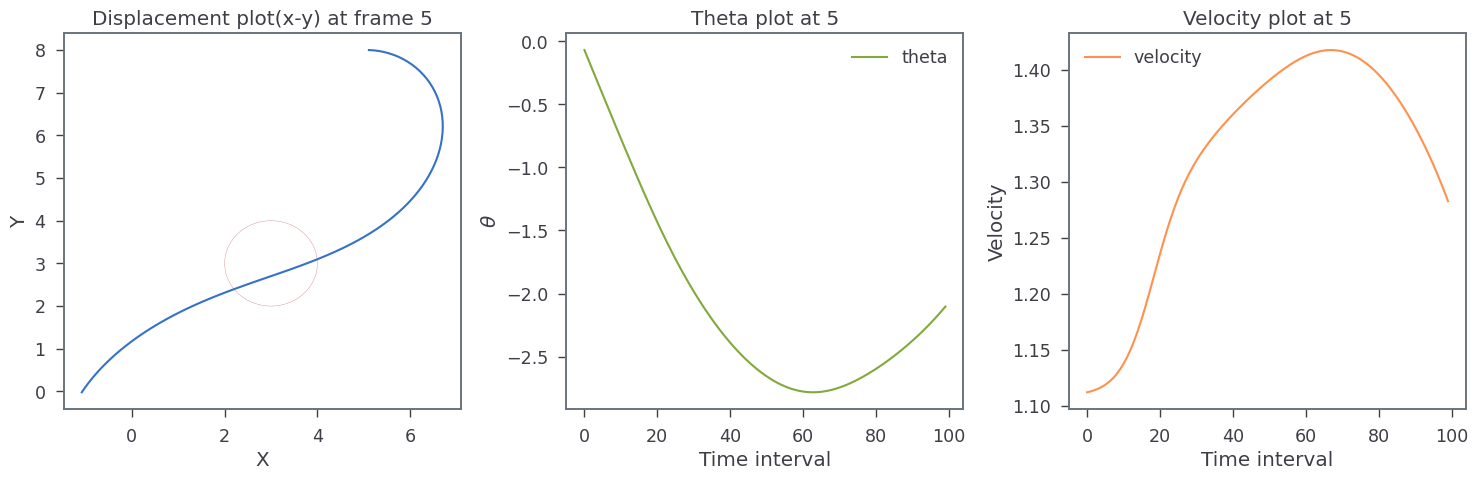

[7] loss: 17.805


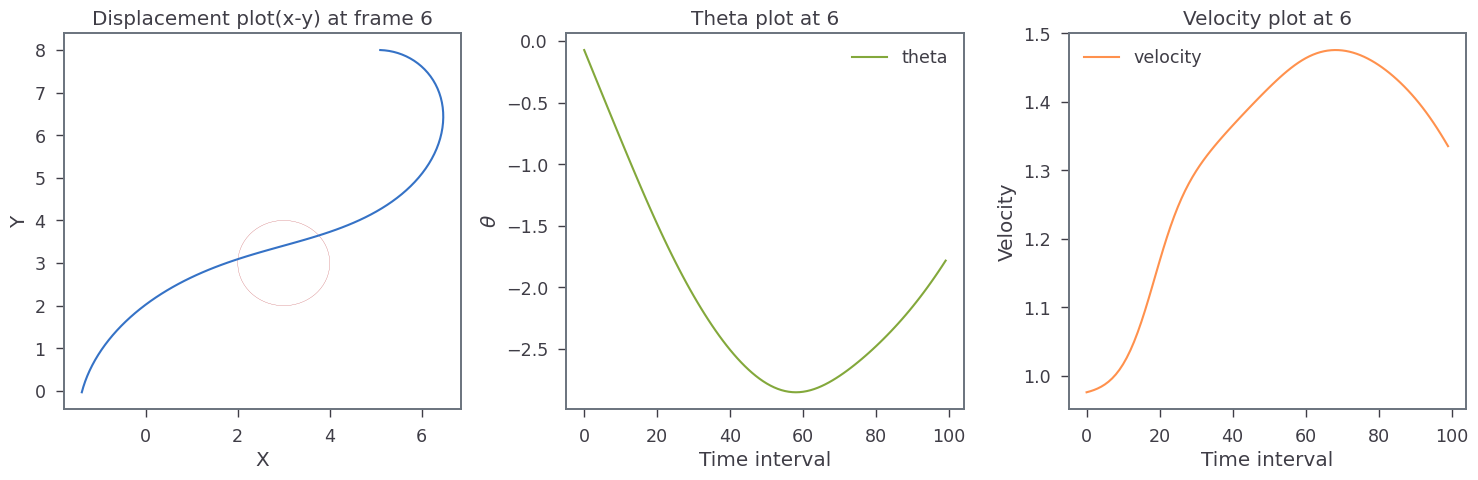

[8] loss: 12.123


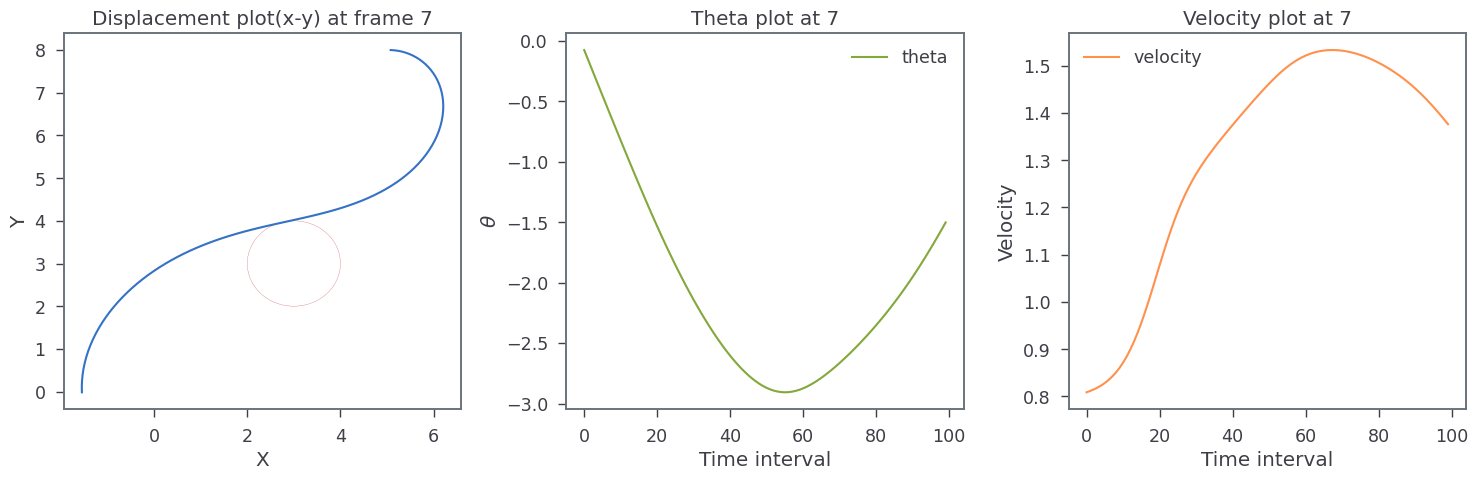

[9] loss: 9.014


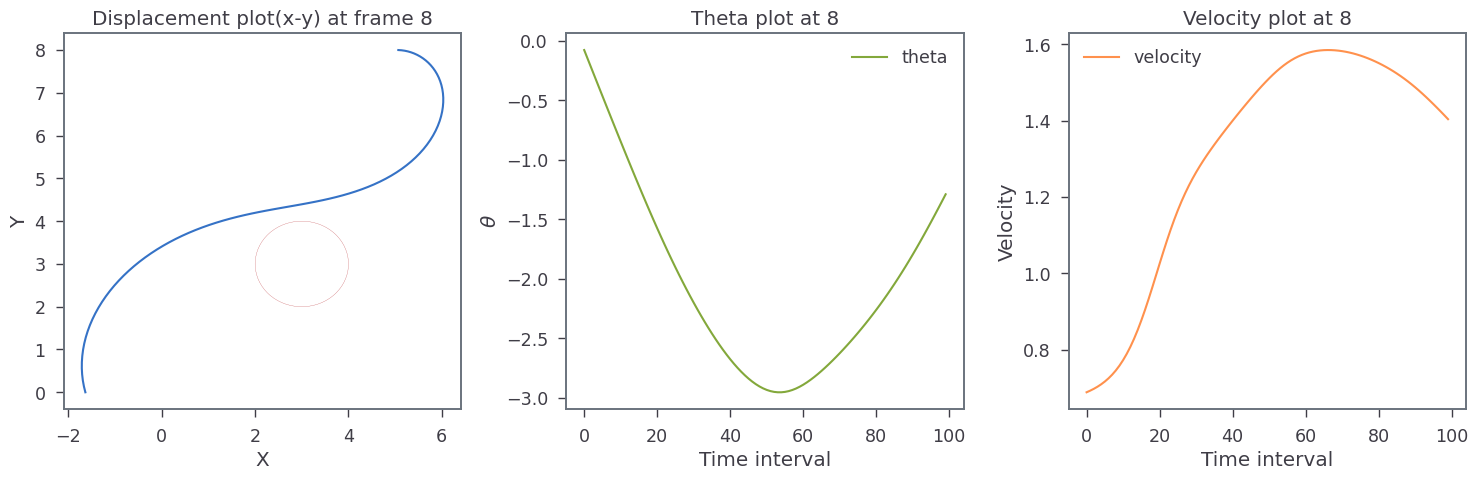

[10] loss: 7.322


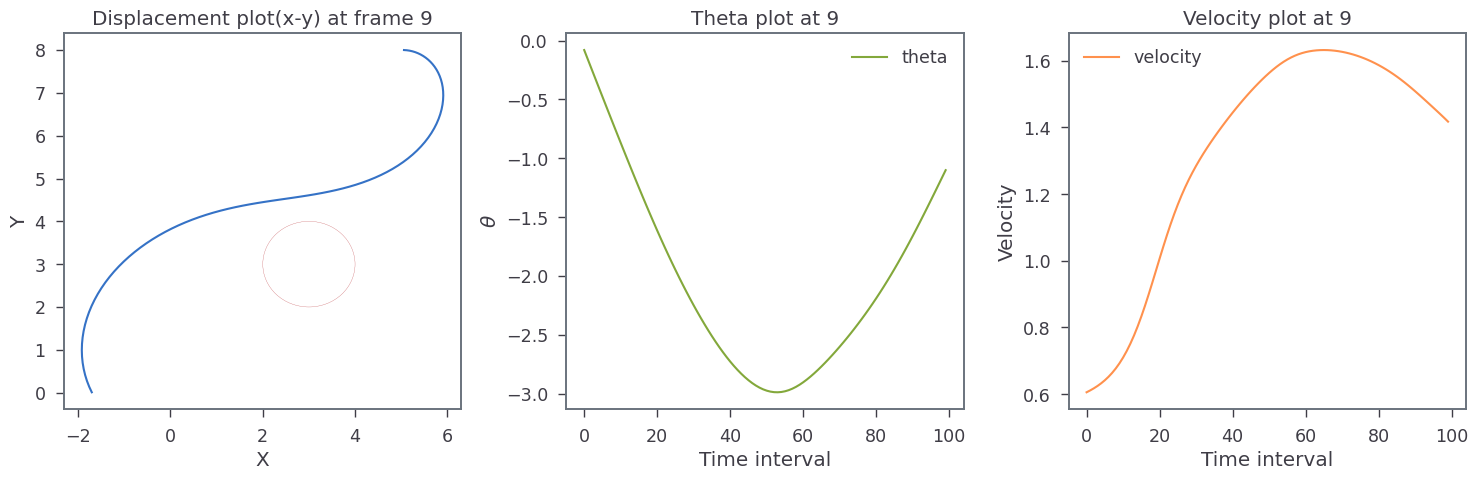

[11] loss: 6.429


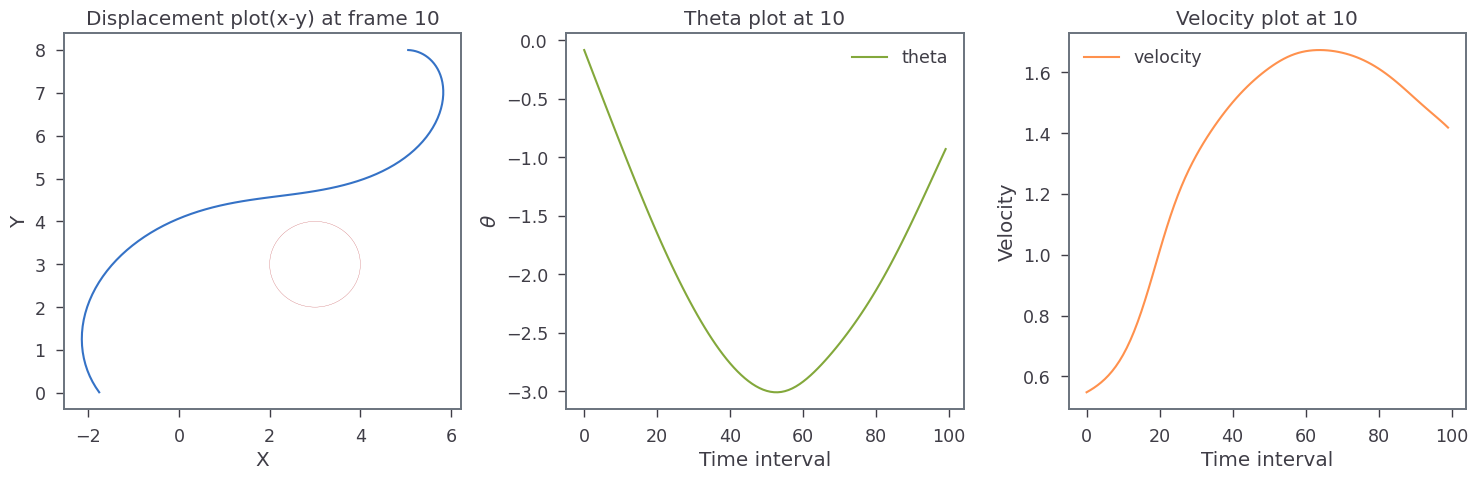

[12] loss: 5.957


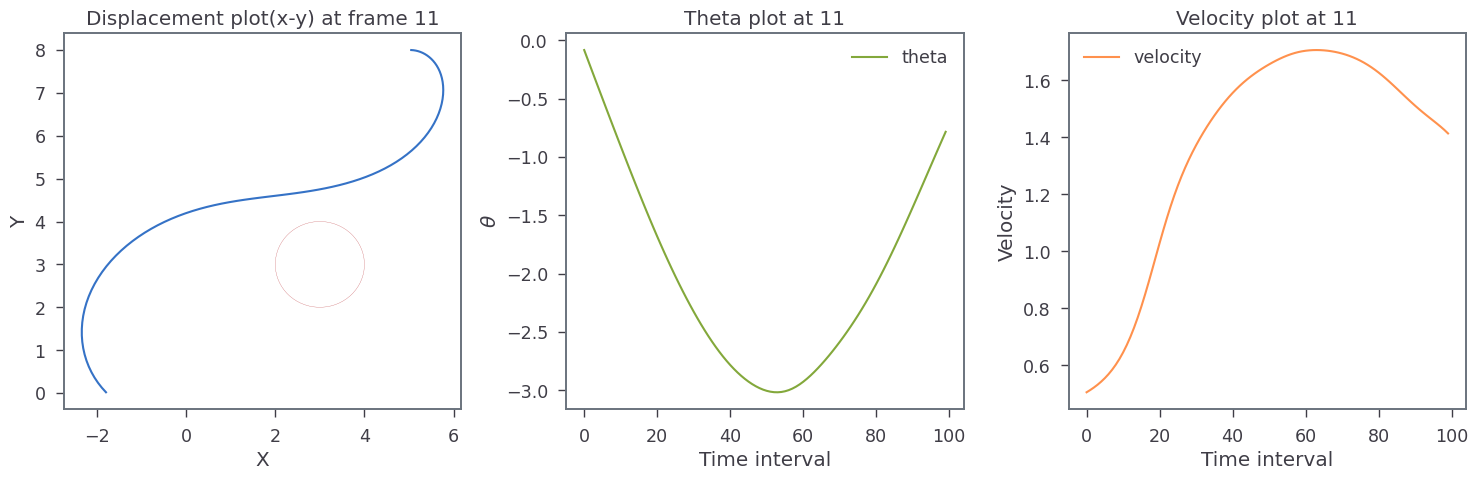

[13] loss: 5.686


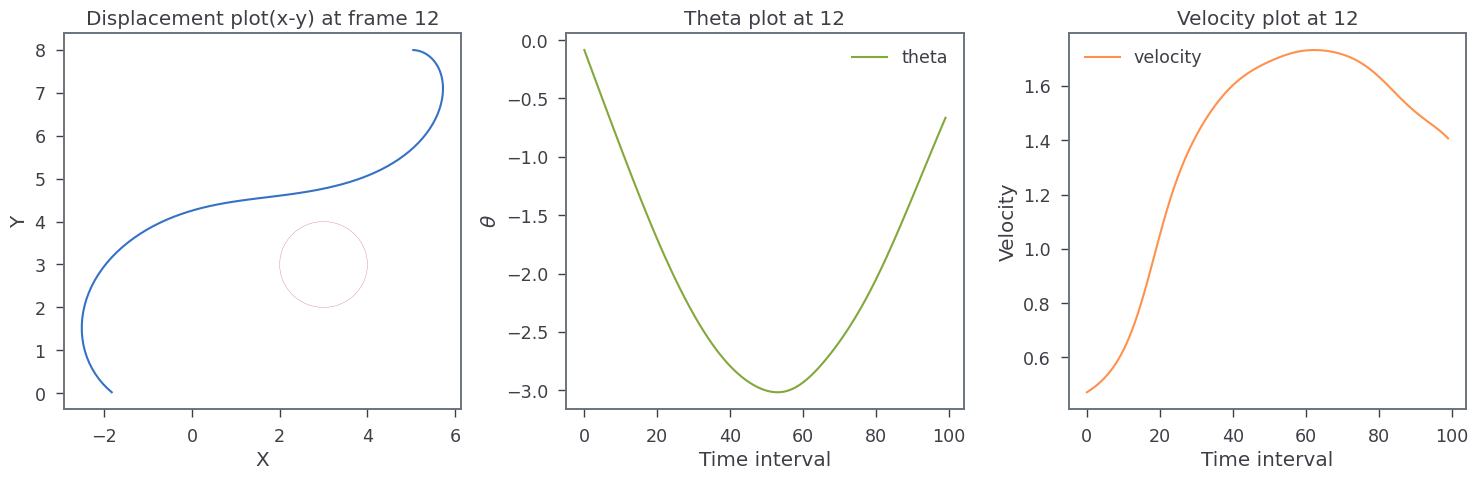

[14] loss: 5.519


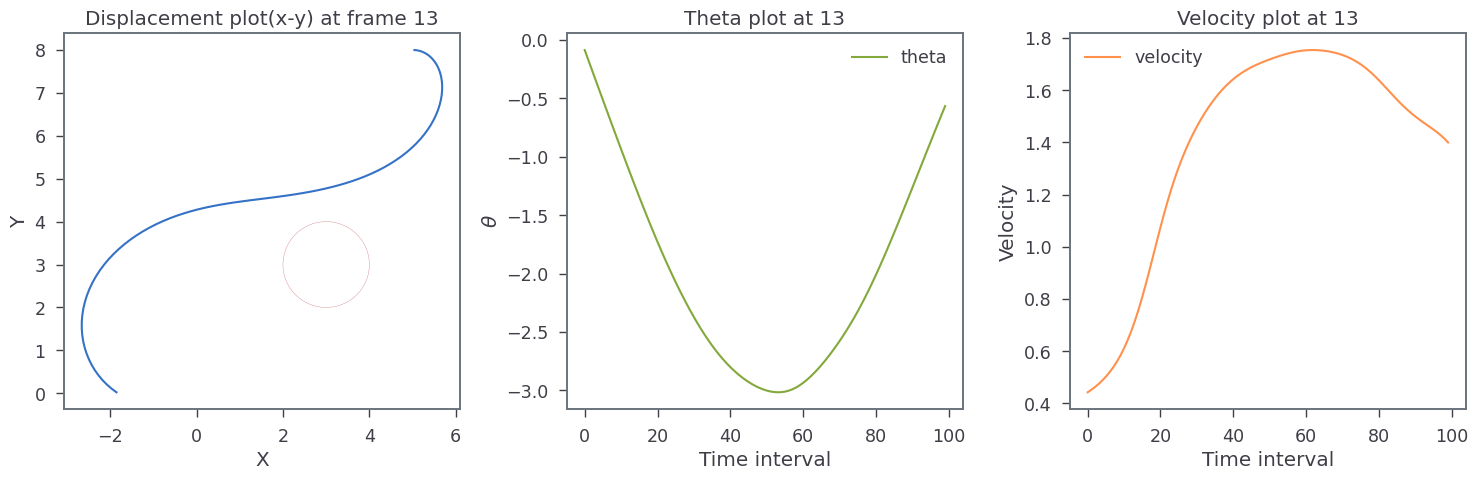

[15] loss: 5.405


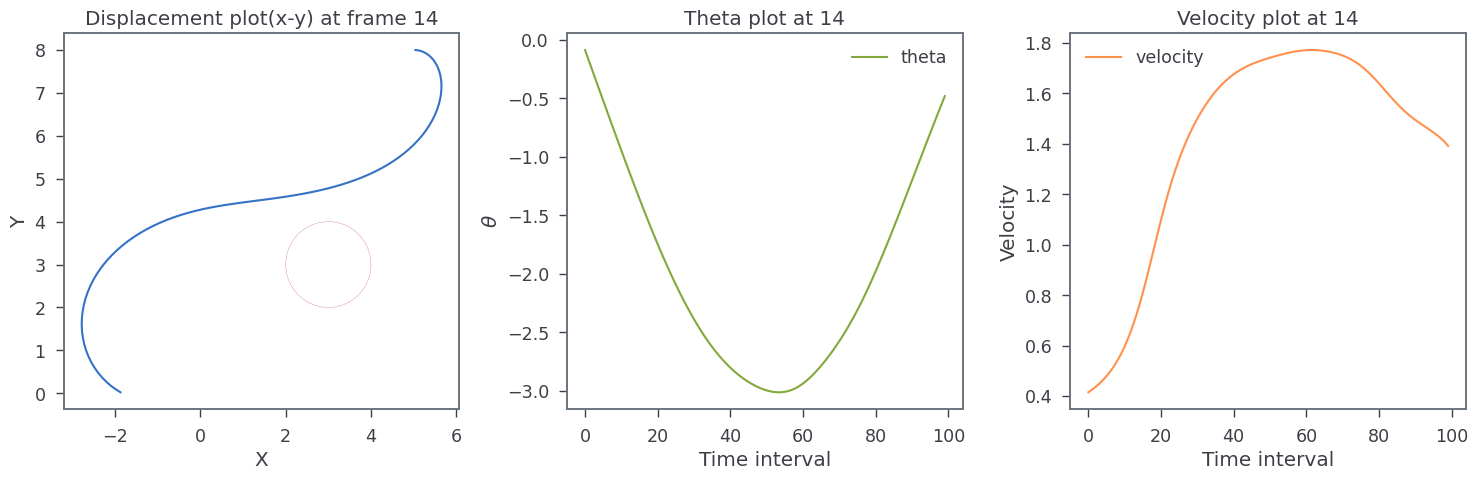

[16] loss: 5.324


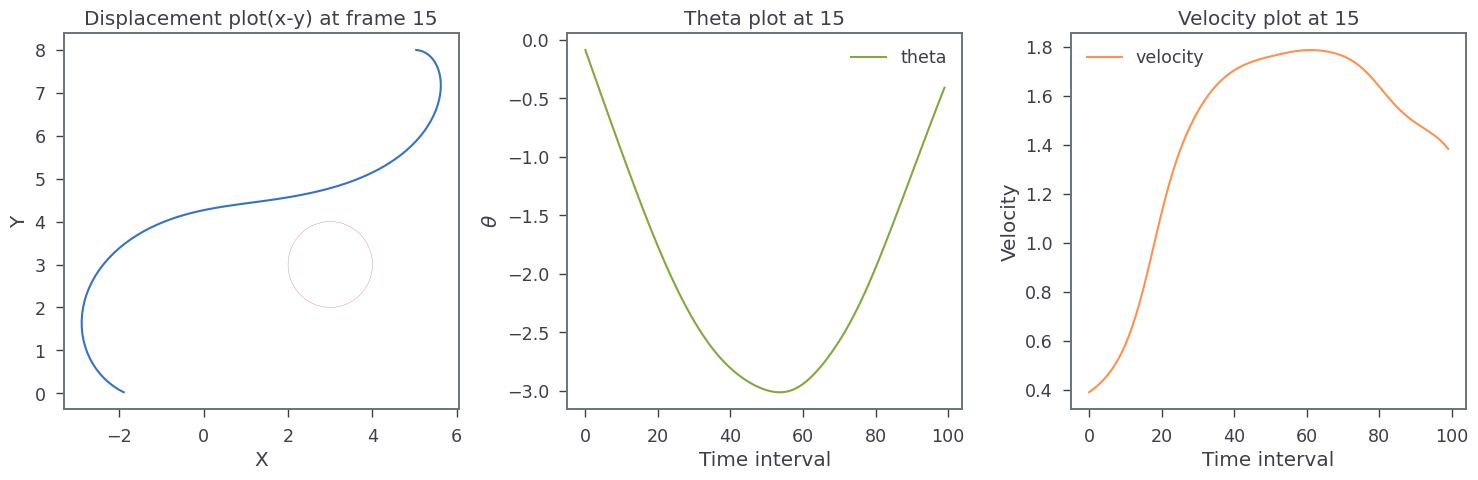

[17] loss: 5.265


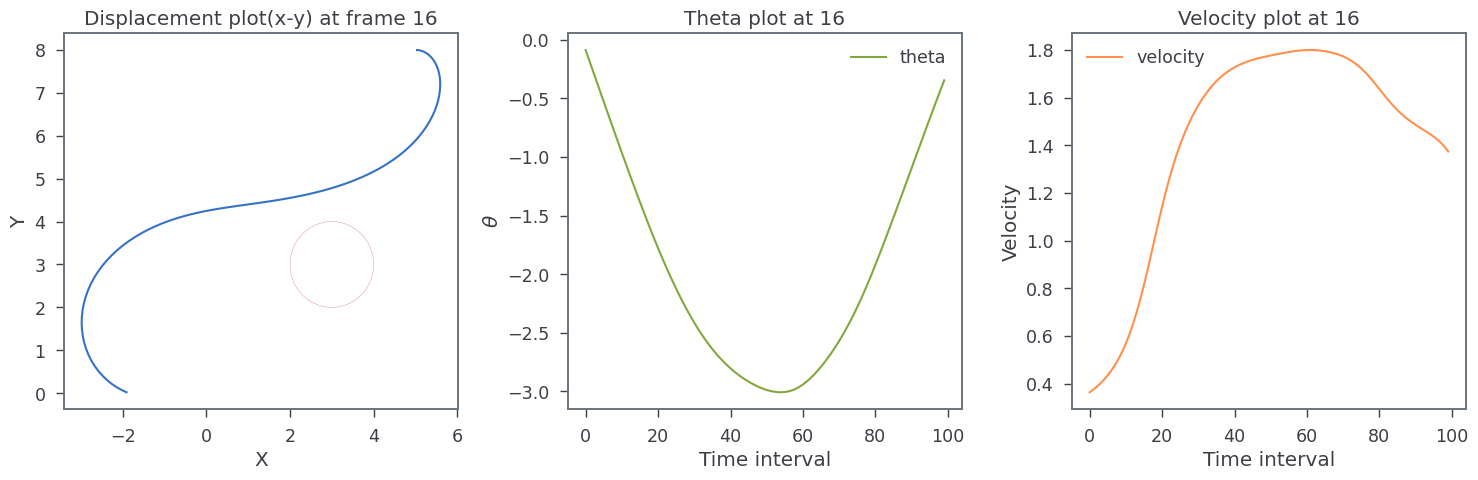

[18] loss: 5.224


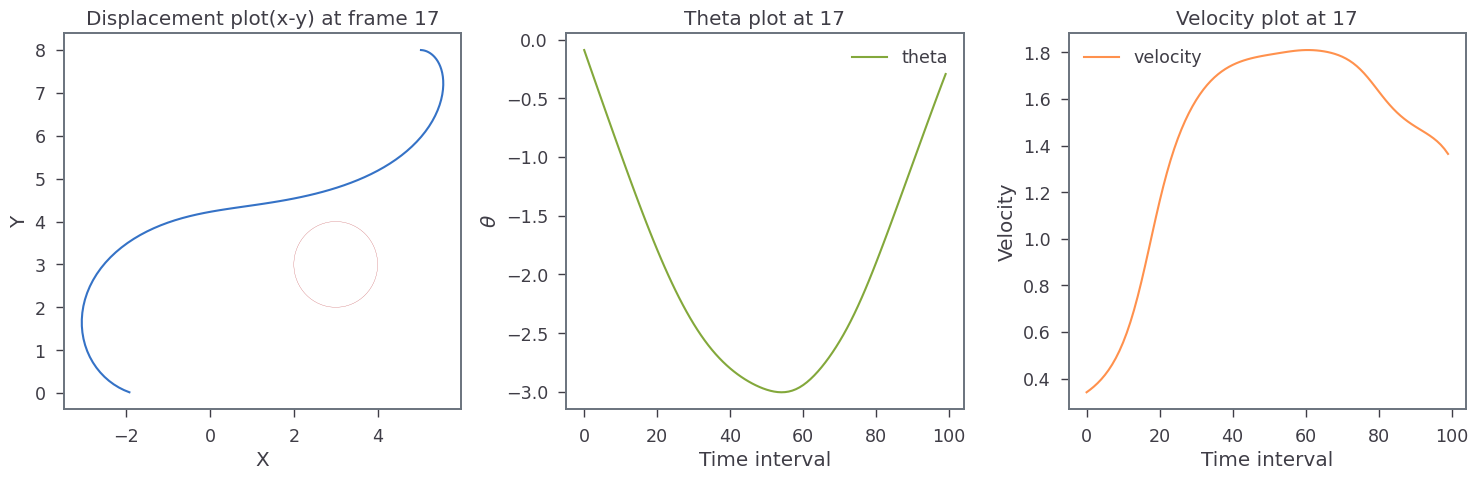

[19] loss: 5.195


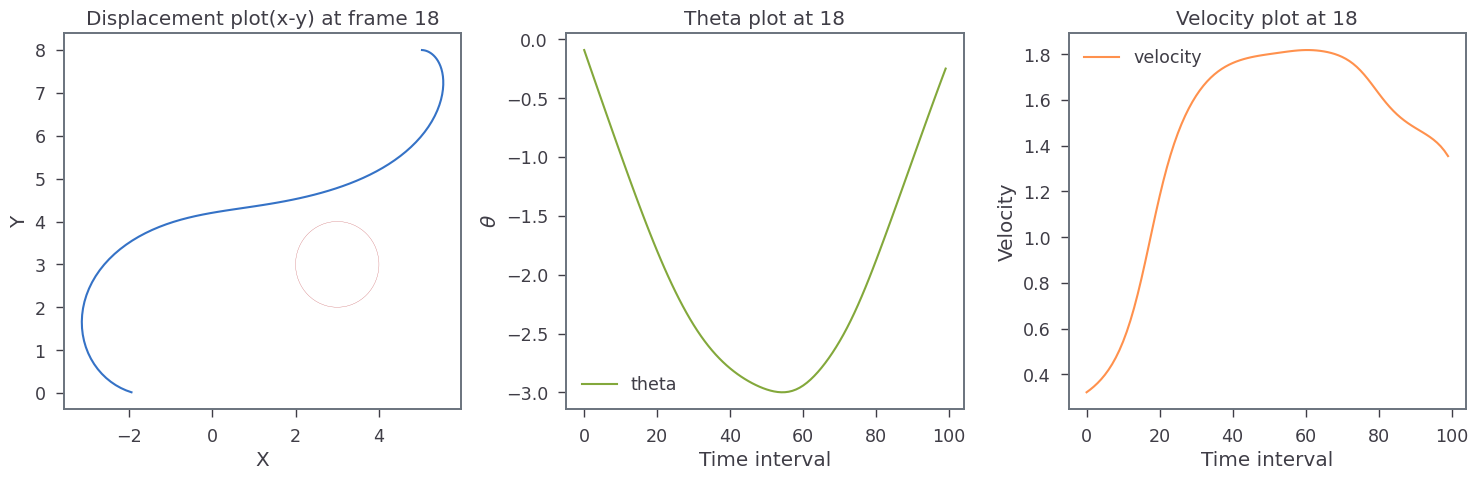

[20] loss: 5.179


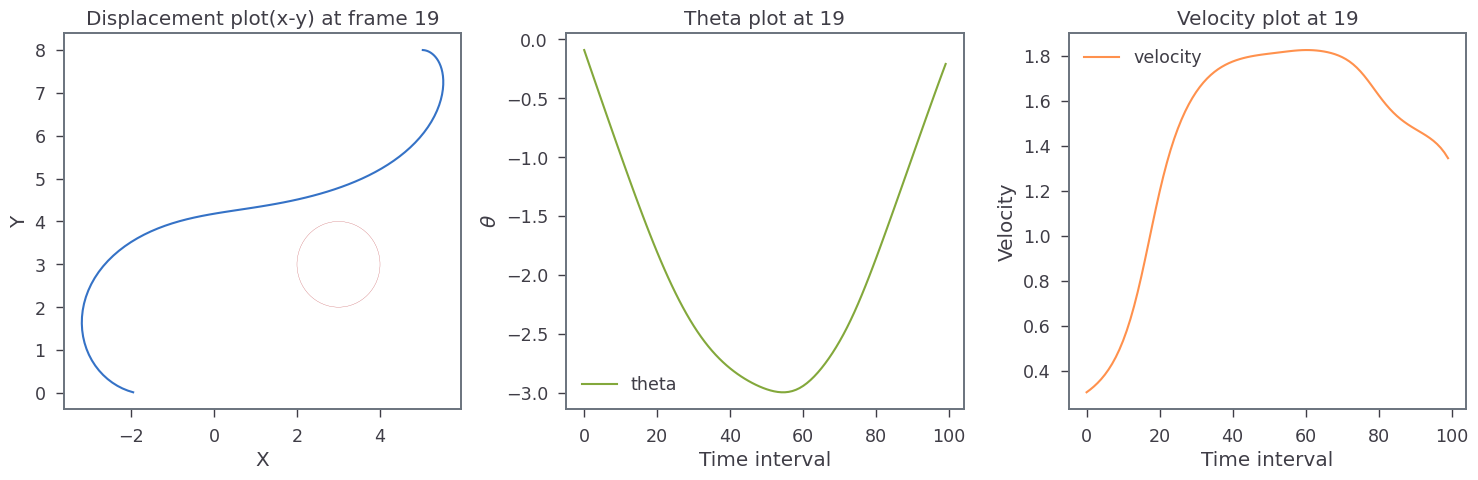

[21] loss: 5.166


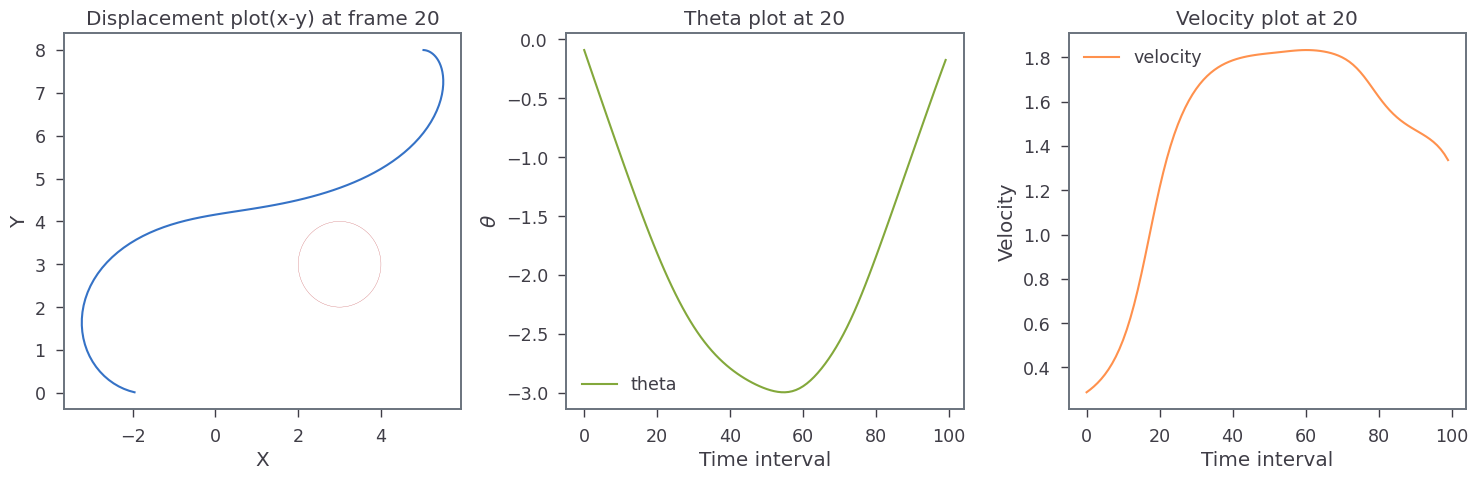

[22] loss: 5.154


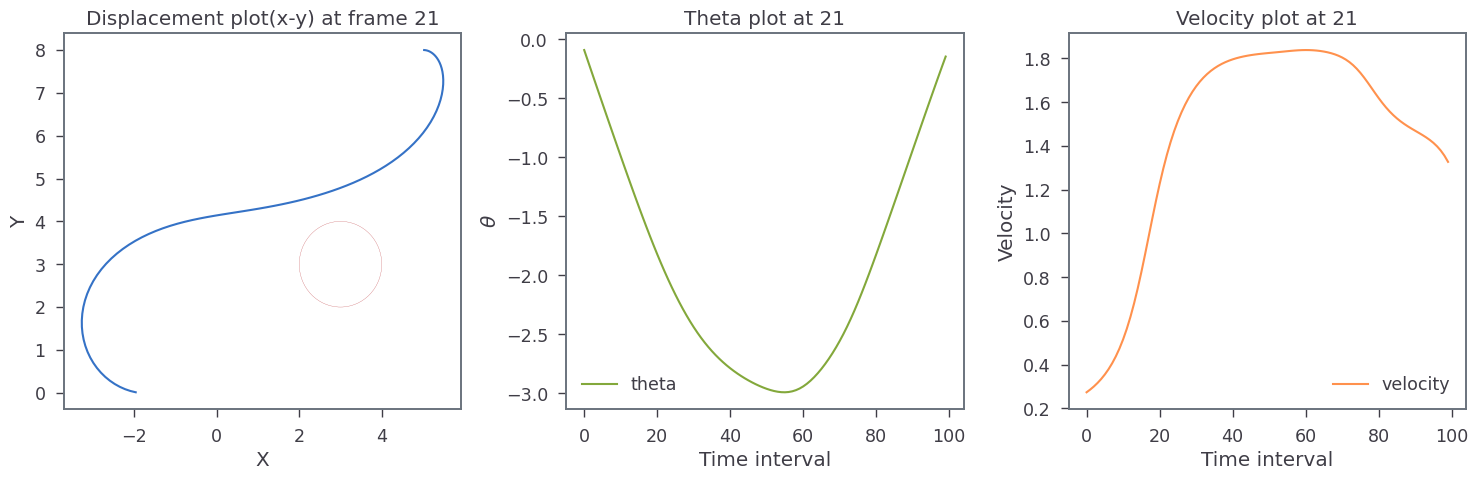

[23] loss: 5.143


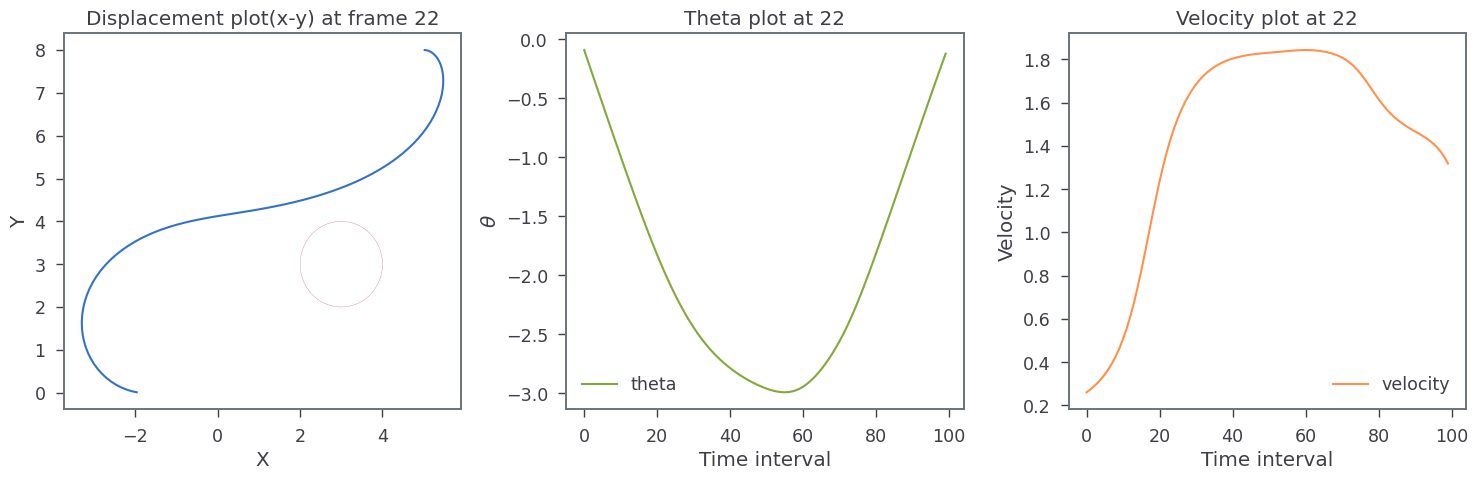

[24] loss: 5.136


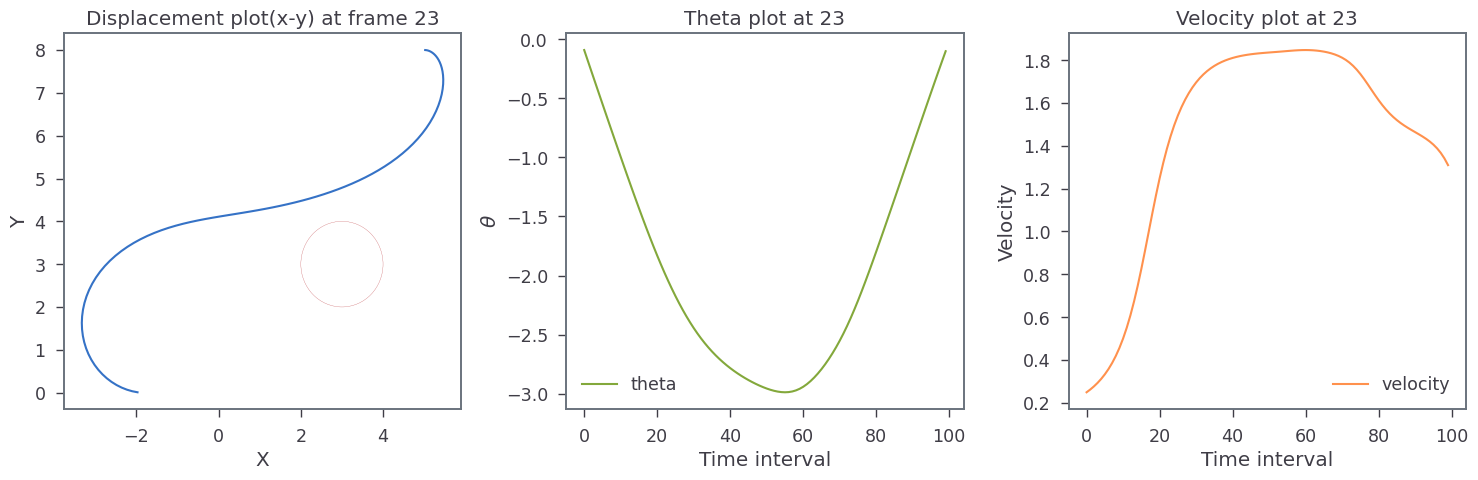

[25] loss: 5.130


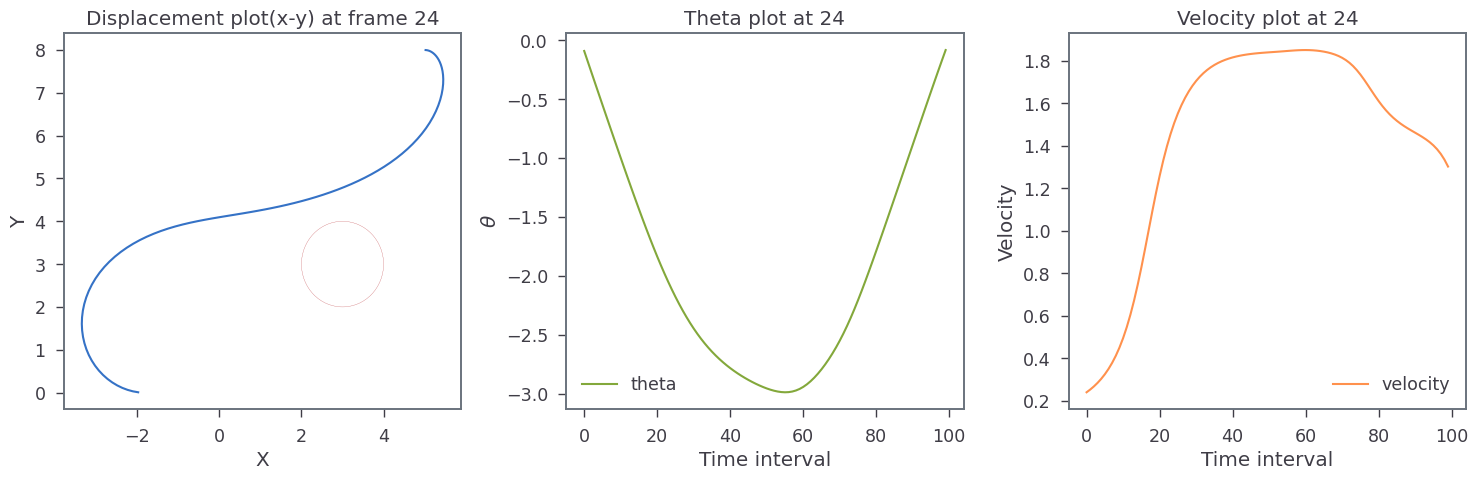

[26] loss: 5.126


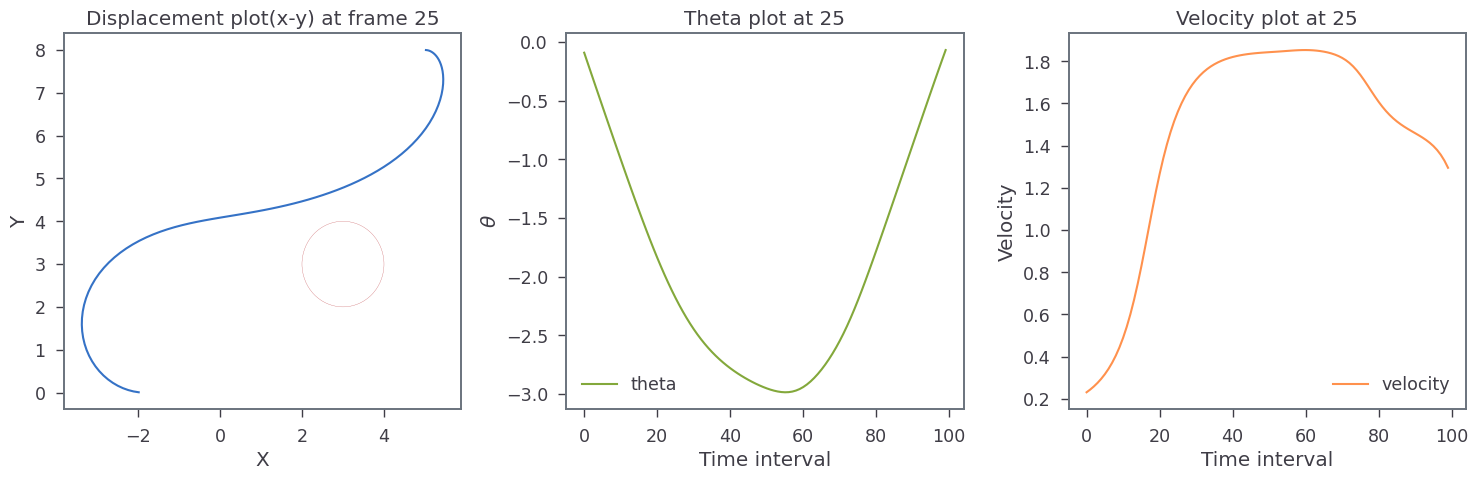

[27] loss: 5.122


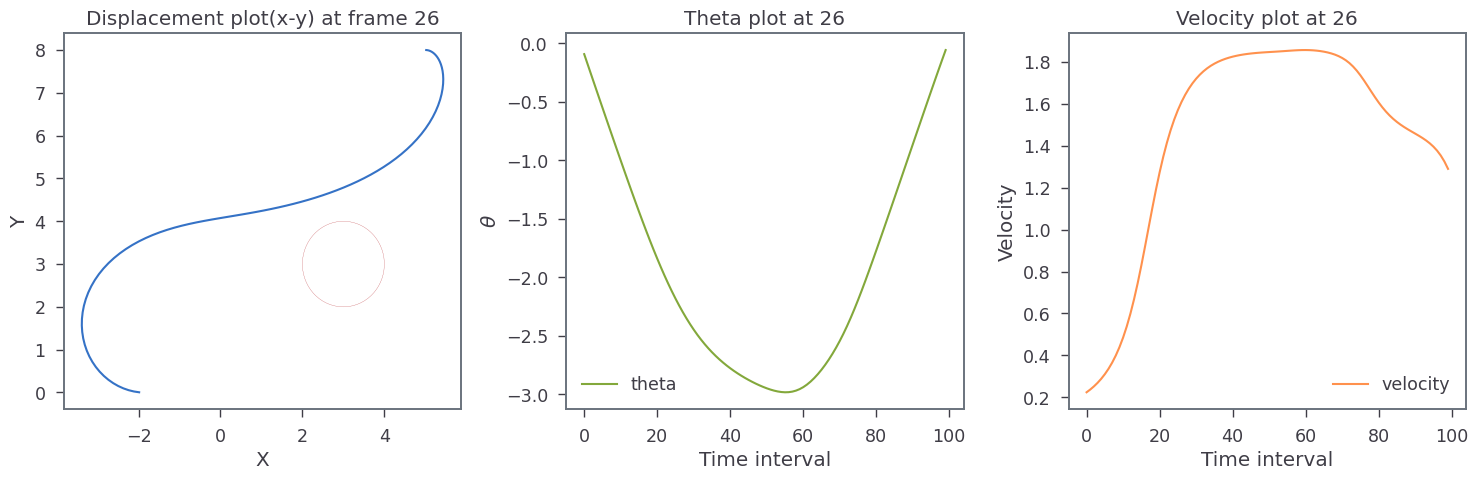

[28] loss: 5.119


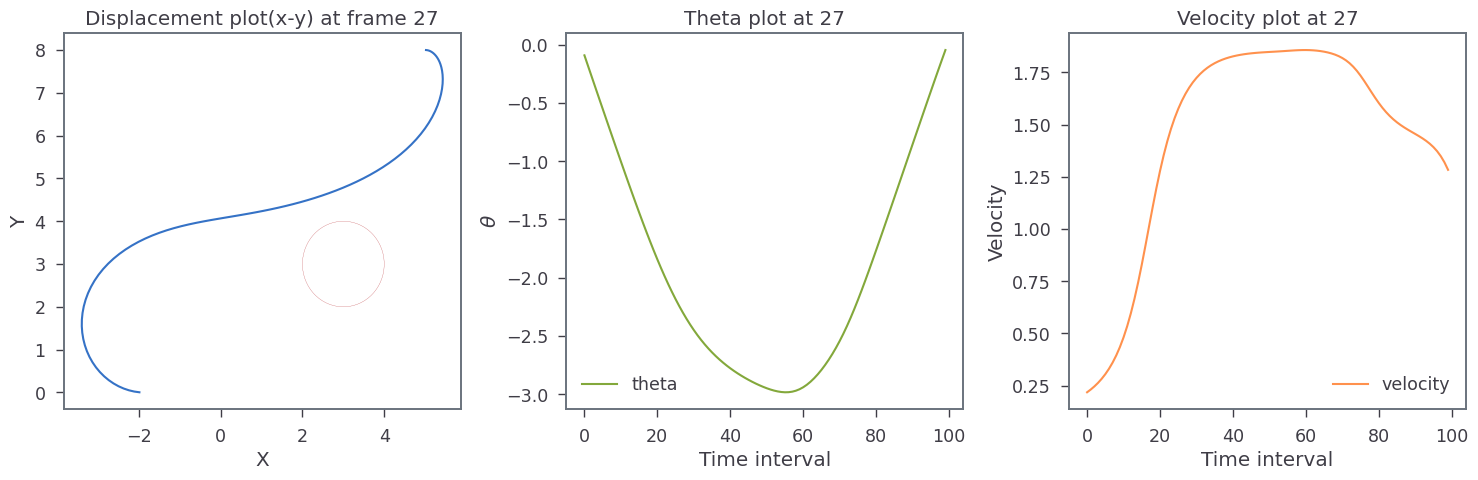

[29] loss: 5.115


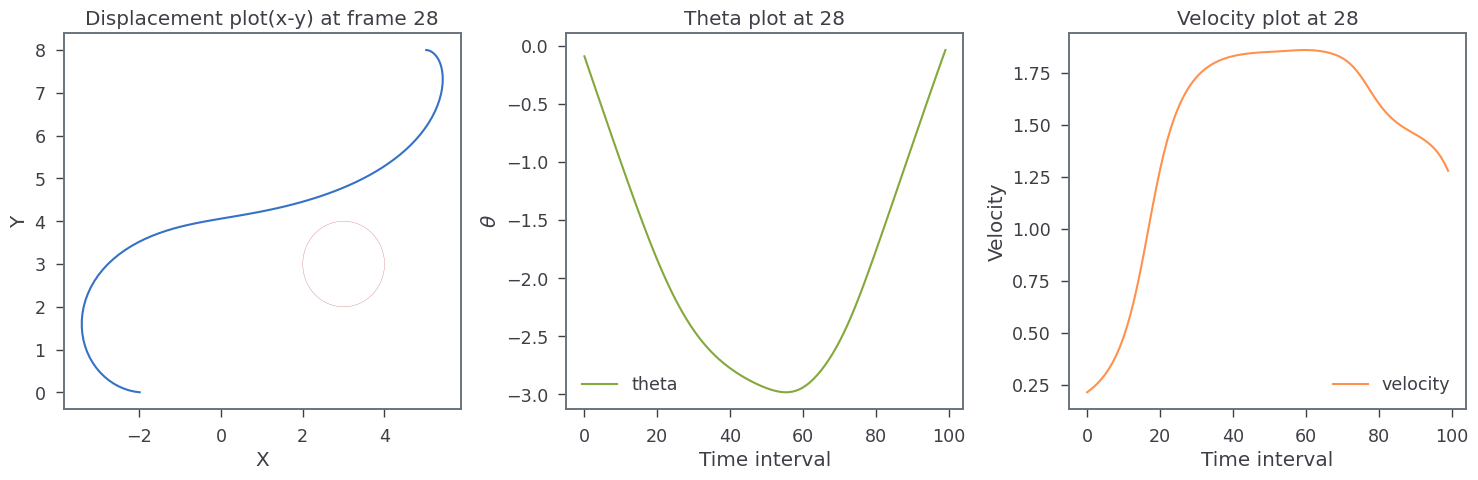

[30] loss: 5.120


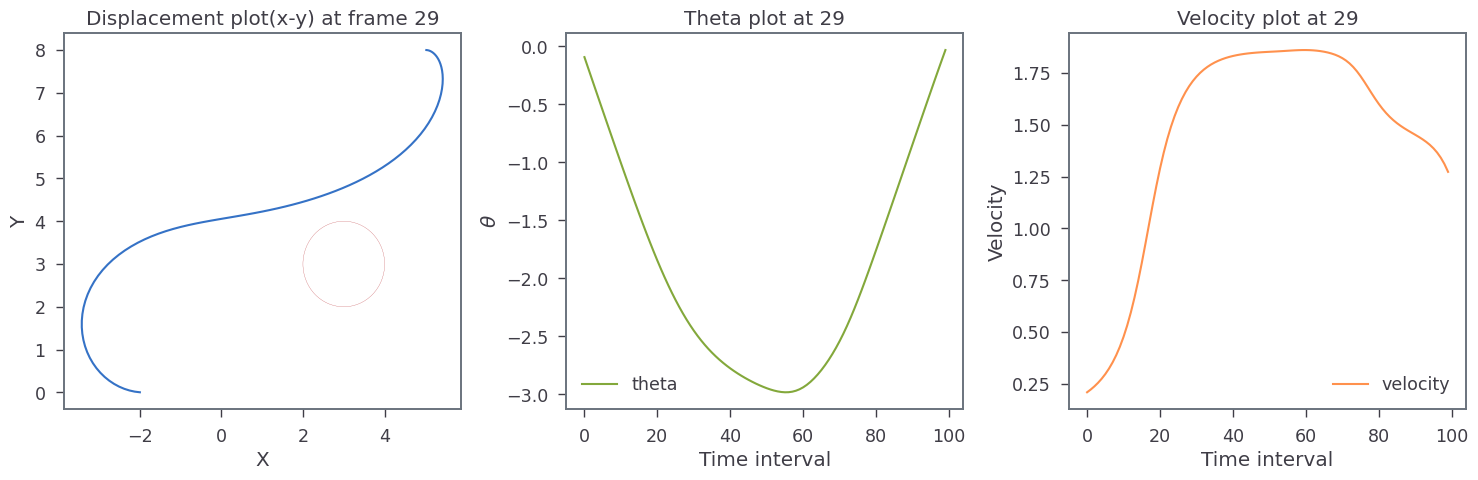

[31] loss: 5.117


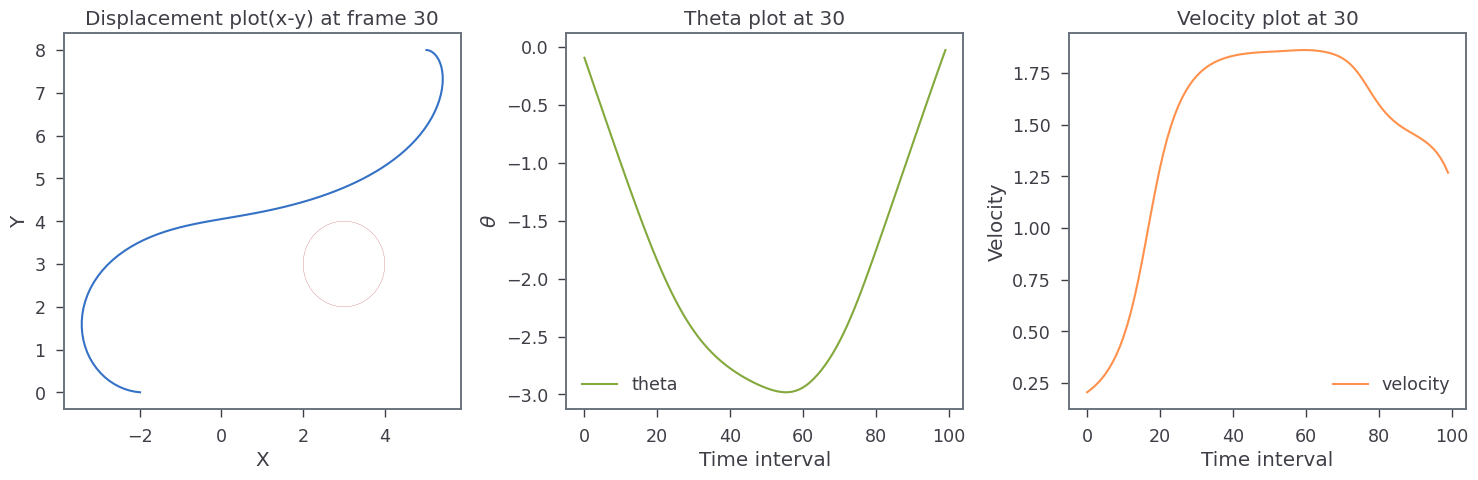

[32] loss: 5.115


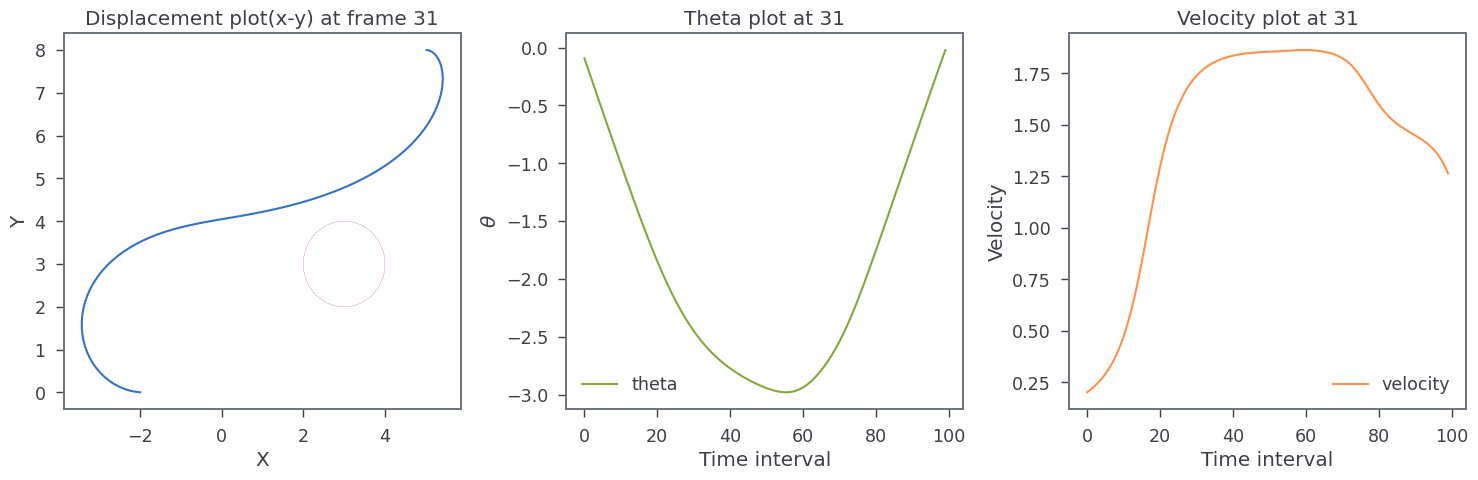

[33] loss: 5.115


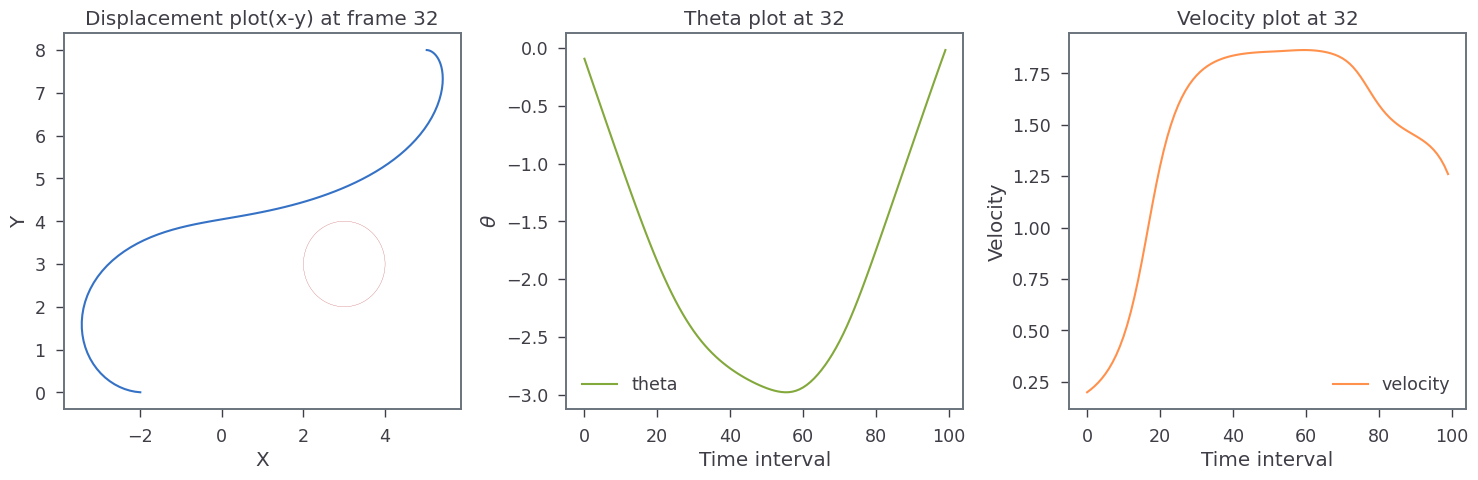

[34] loss: 5.113


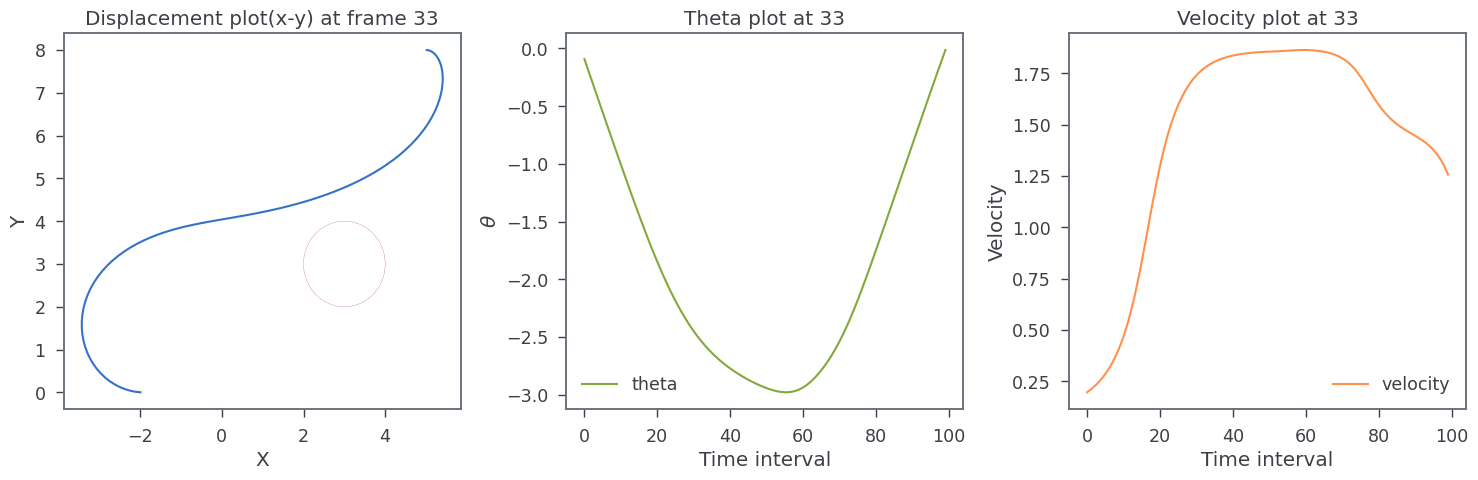

[35] loss: 5.111


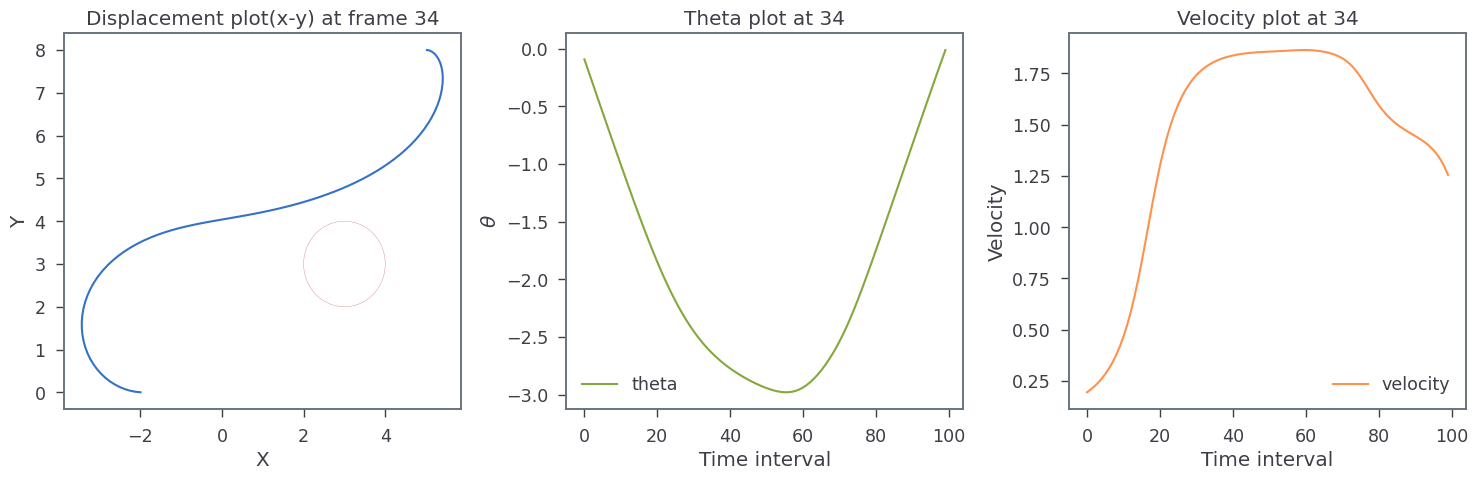

[36] loss: 5.109


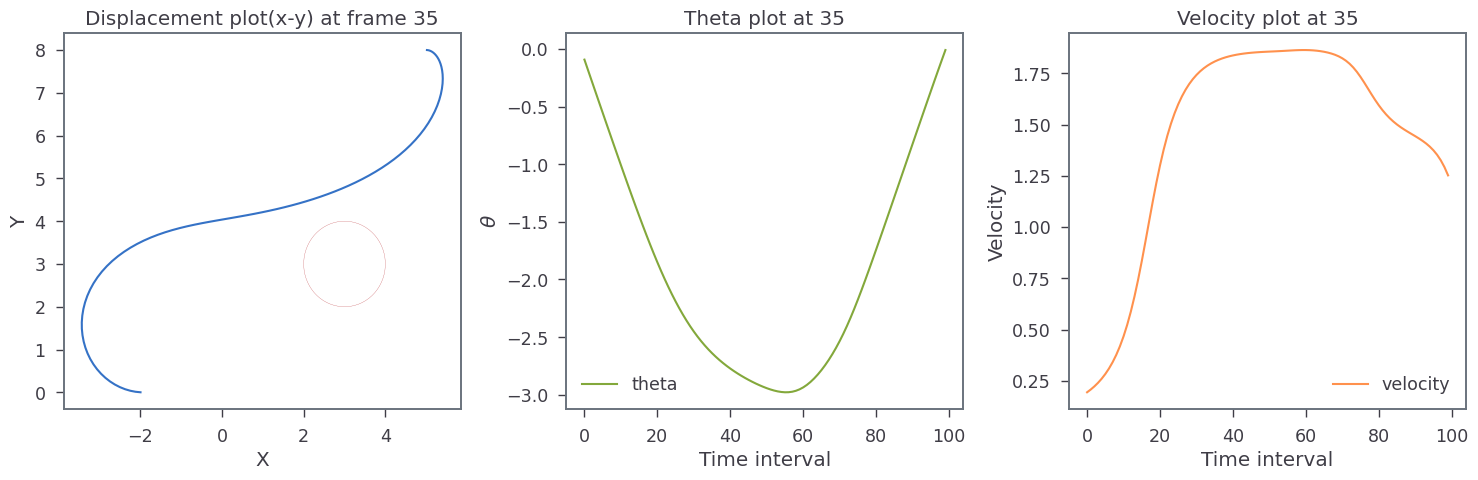

[37] loss: 5.107


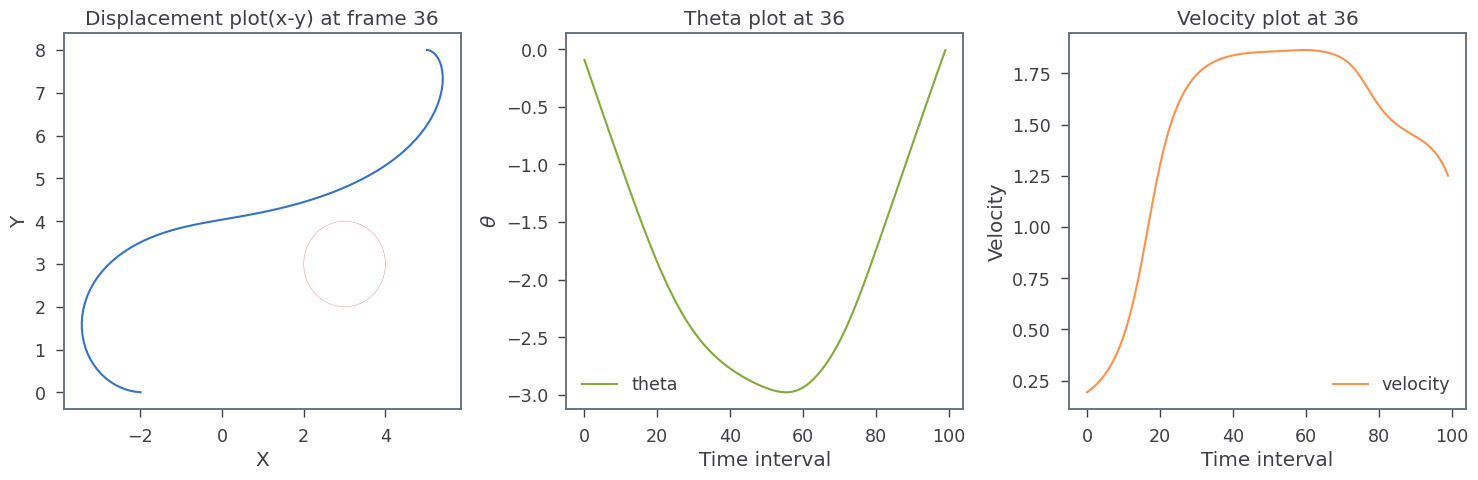

[38] loss: 5.106


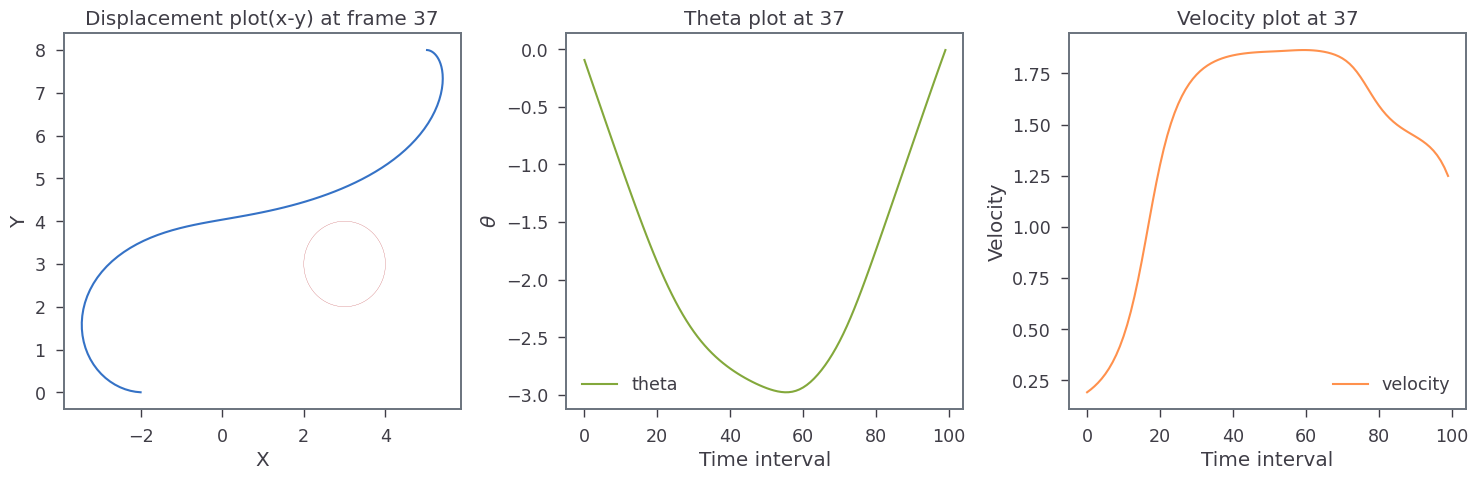

[39] loss: 5.100


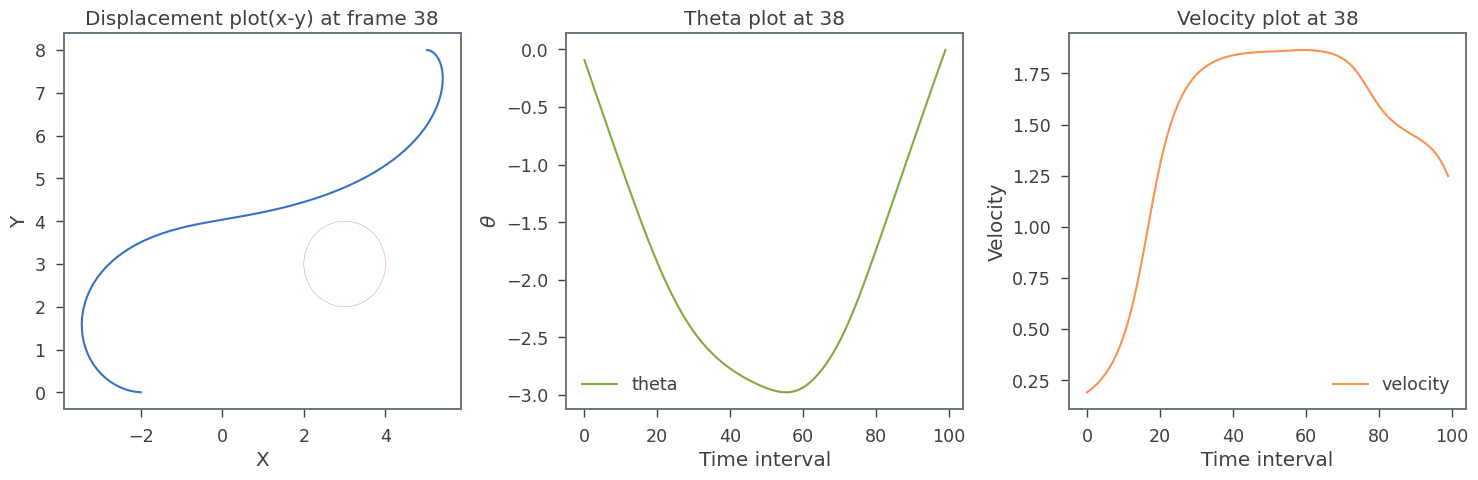

[40] loss: 5.101


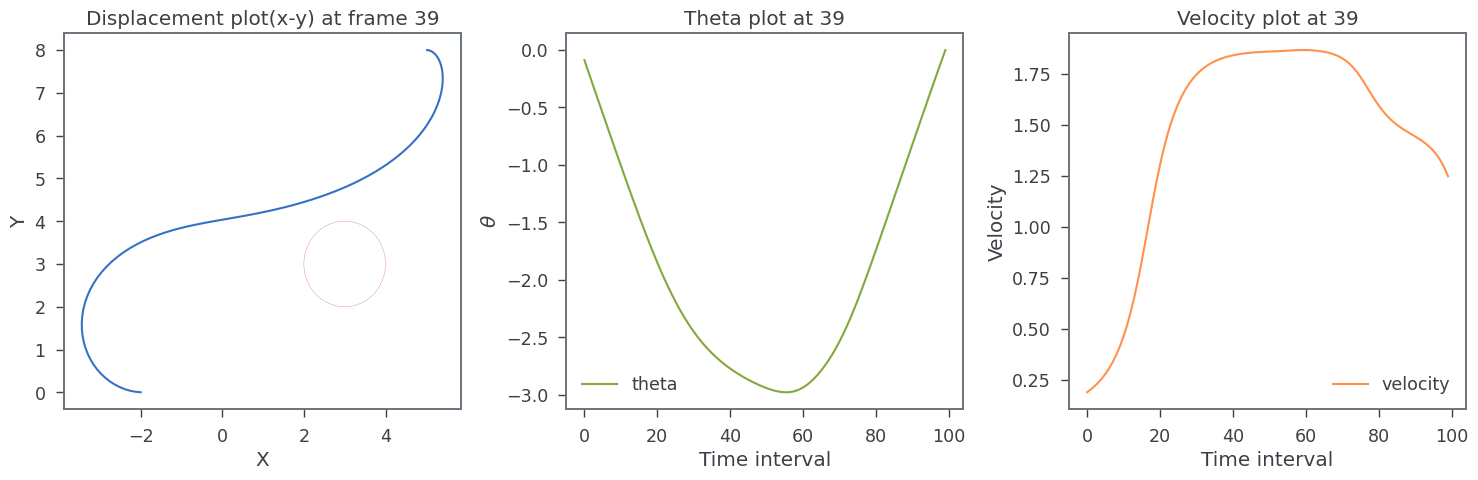

[41] loss: 5.101


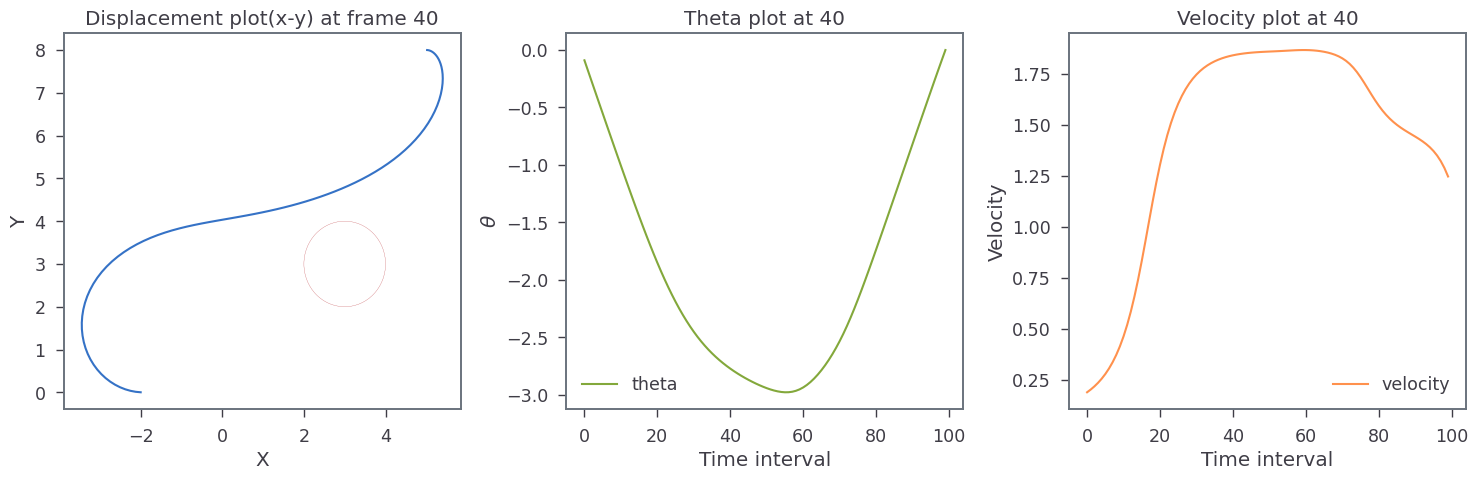

[42] loss: 5.102


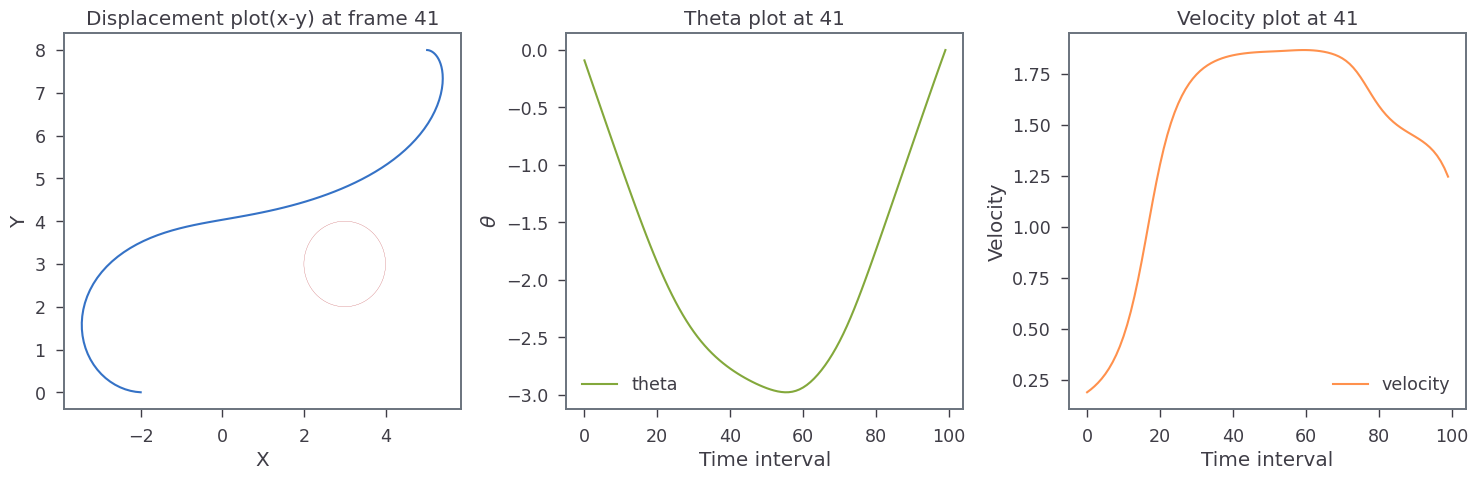

[43] loss: 5.101


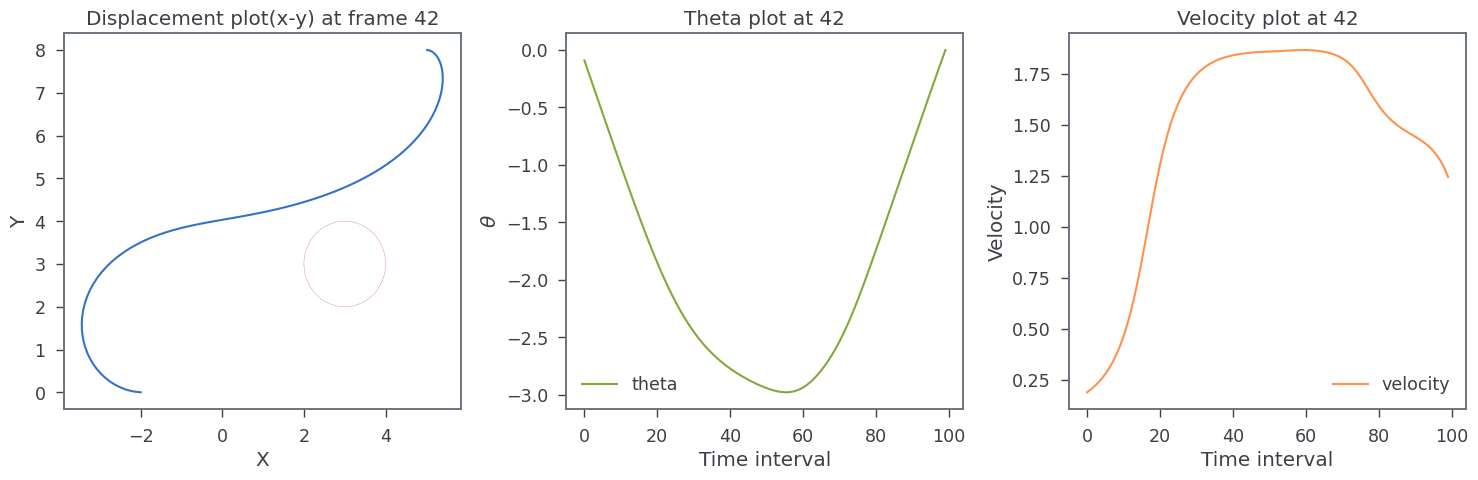

[44] loss: 5.099


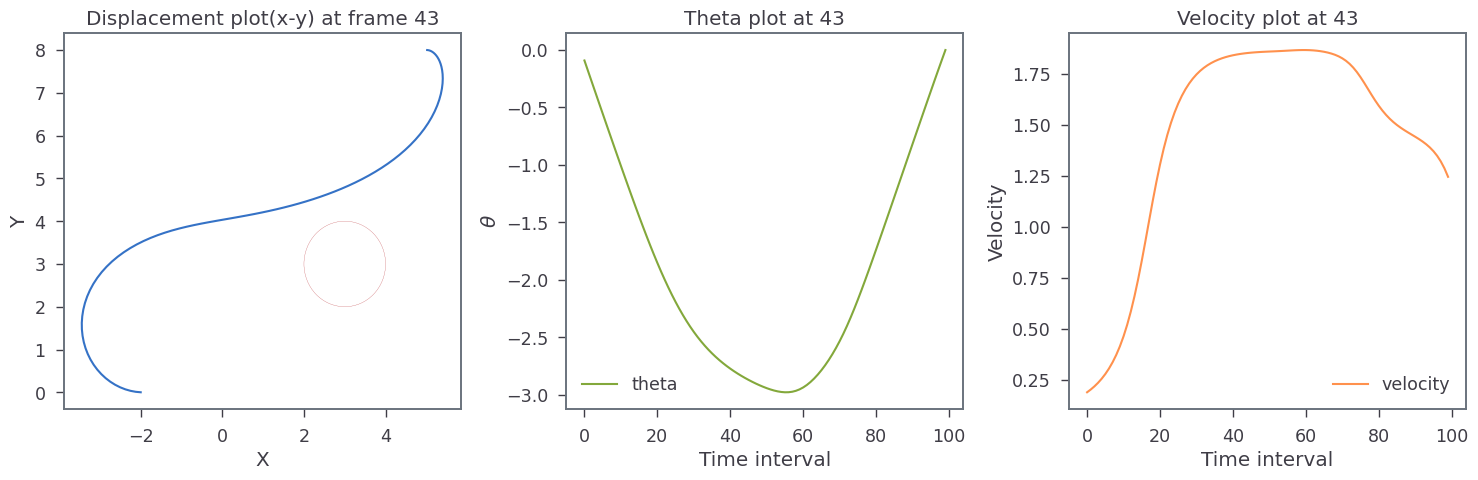

[45] loss: 5.097


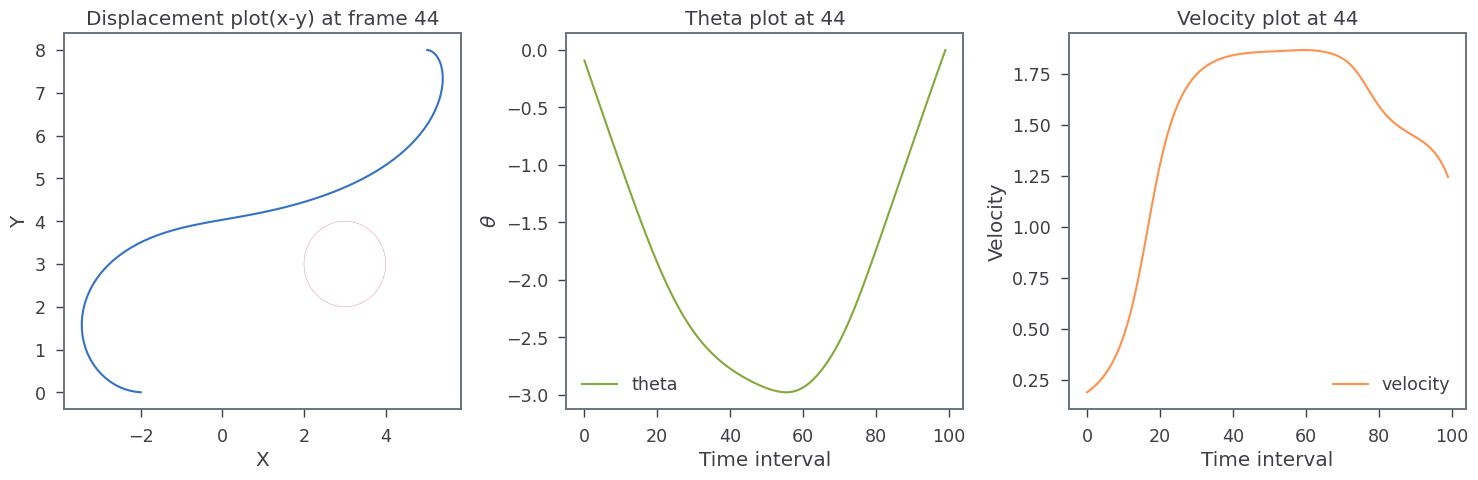

[46] loss: 5.096


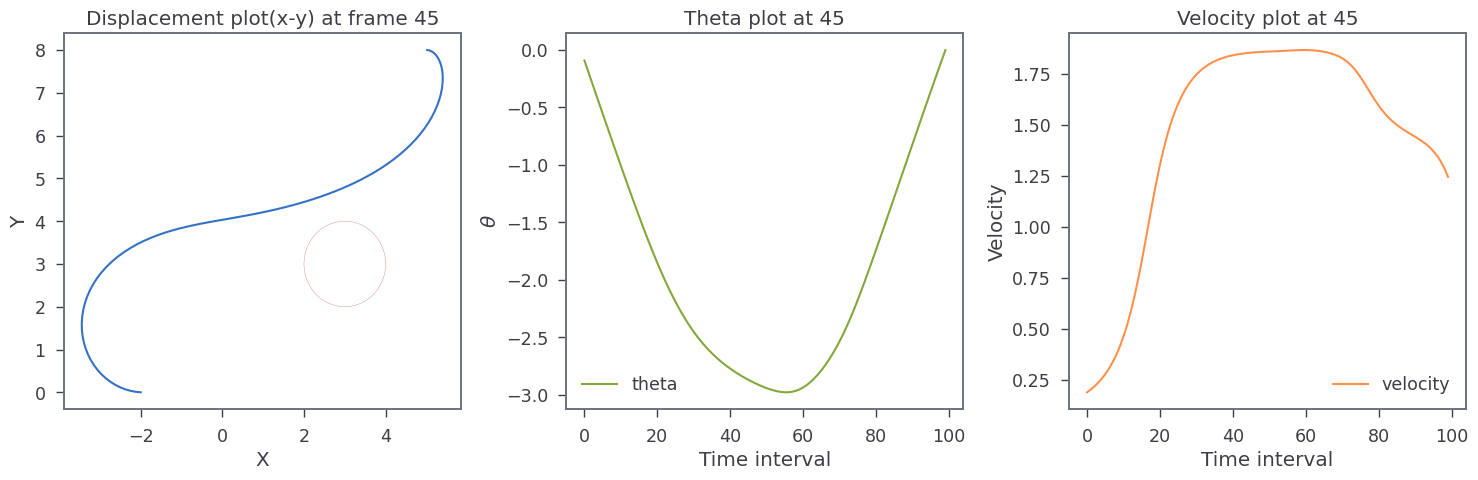

[47] loss: 5.095


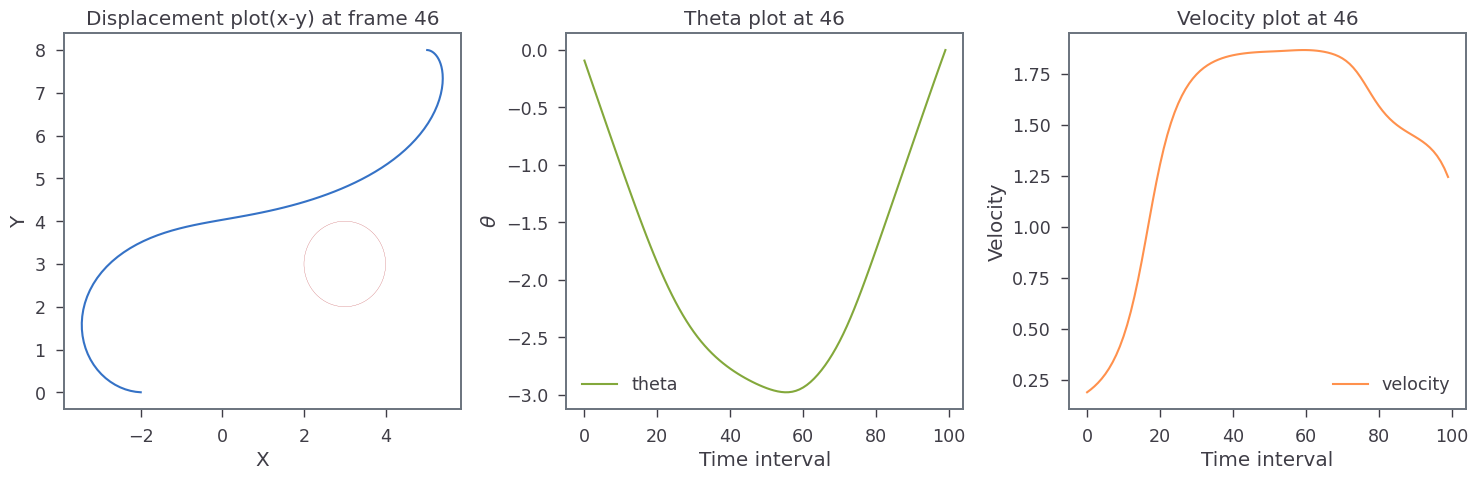

[48] loss: 5.094


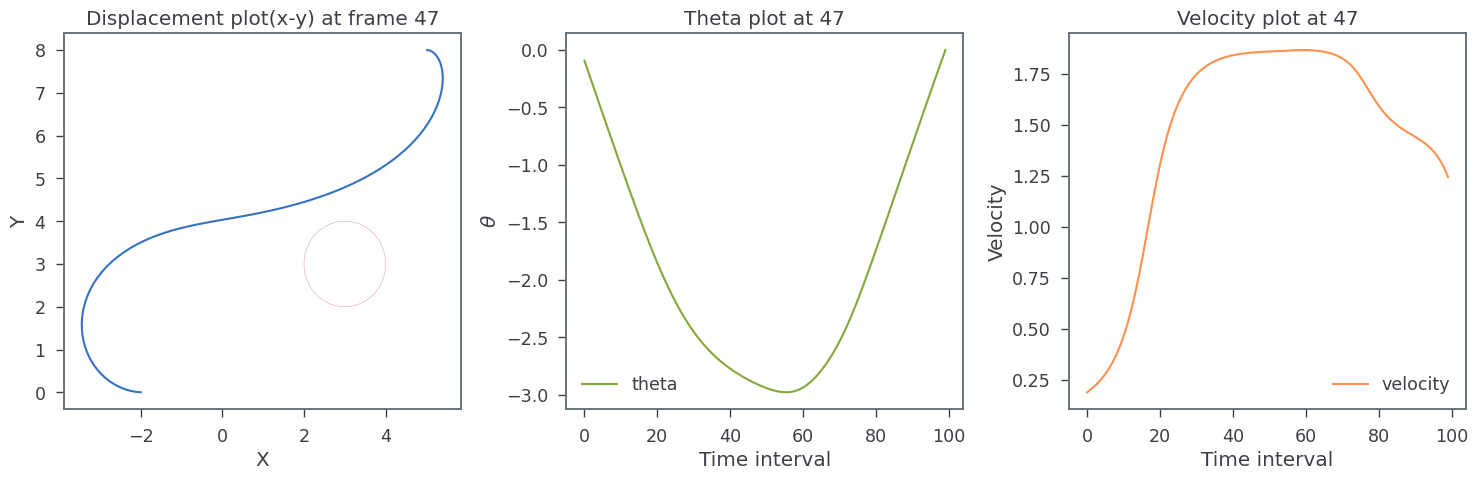

[49] loss: 5.093


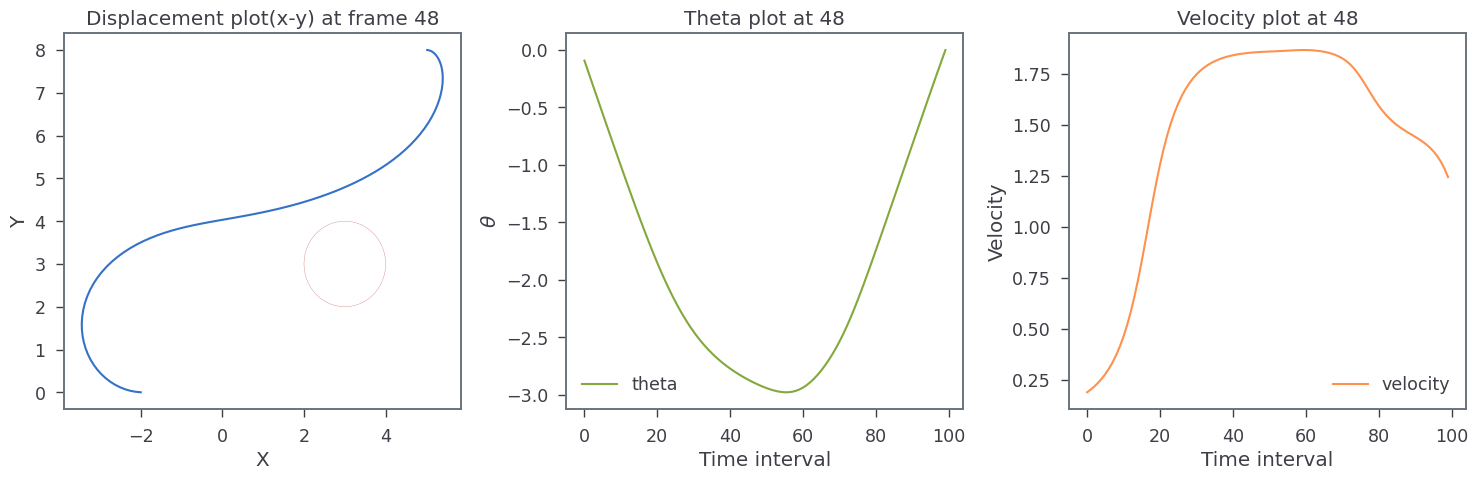

[50] loss: 5.093


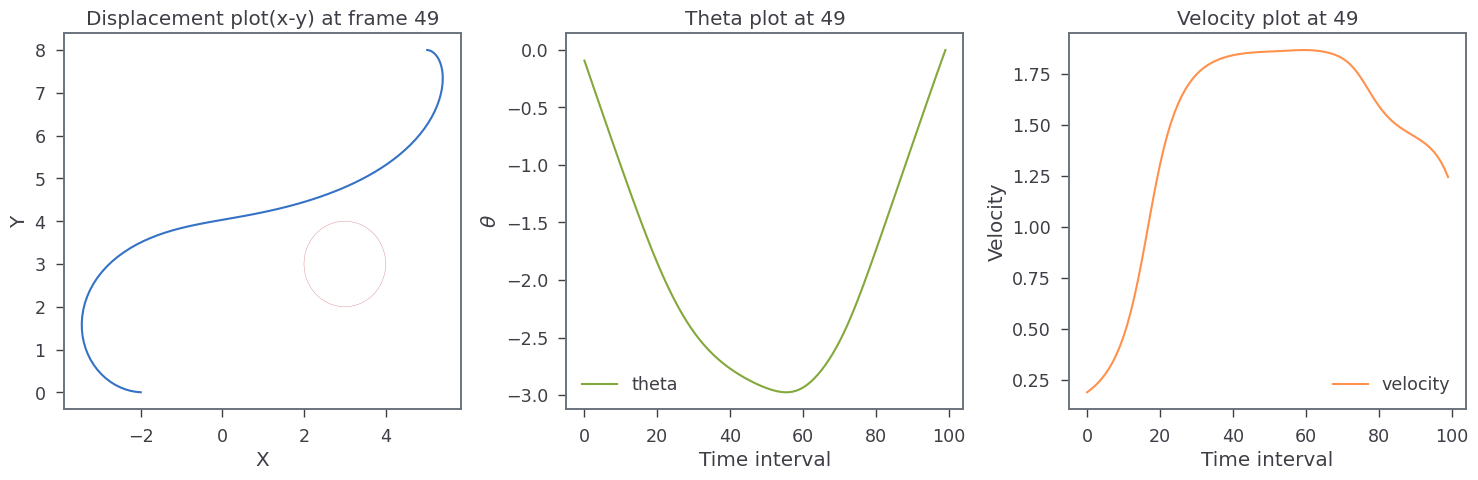

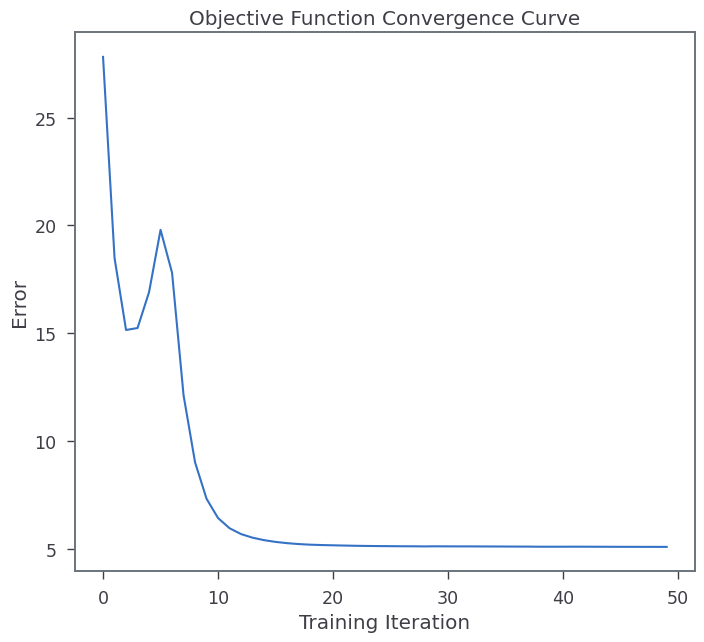

Generating Animation


IntProgress(value=0, max=101)

(100, 3) (100, 2)


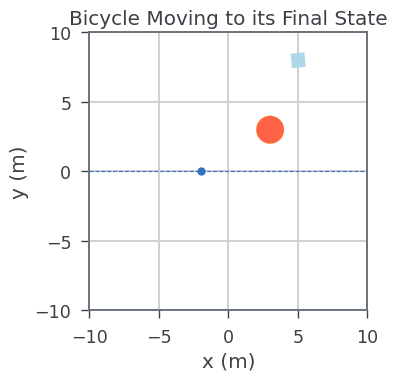

In [ ]:
T = 100  # number of time steps of the simulation # 100

dim_input = 3  # state space dimensions # 5
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions # 2

d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)

o.train(50)  # training with number of epochs (gradient descent steps)
# o.train(5)  # training with number of epochs (gradient descent steps)


## **Visualization and Analysis of the results**:
As seen in the gif the bicycle model avoids the rocket that landed in the example problem. Therefore, this path planning problem has been solved.


## Issues and lessons learned when solving this problem are as follows:

1) Forgetting that Indexing starts at 0 and not 1 was large issues when it came to debugging. MATLAB is my language of choice. I should have used the print function more often when debugging.


2) Using the wrong number of state variables.
I was confusing state and action variables.


3) Incorrectly using action variables.
I was incorrectly indexing and defining variables.


4) Trying to solve the discrete-time dynamics without substituting $\dot{x}$, $\dot{y}$, and $\dot{\theta}$ in terms of v, $\theta$, $\Delta t$, and $\omega$.

$$
\begin{aligned}
& x(t+1) = x(t) + \dot{x}(t) \Delta t, \\
& y(t+1) = y(t) + \dot{y}(t) \Delta t, \\
& \theta(t+1) = \theta(t) + \dot{\theta}(t) \Delta t,
& \end{aligned}
$$

$$
\begin{aligned}
& x(t+1) = x(t) + v * cos(\theta)\Delta t, \\
& y(t+1) = y(t) + v * sin(\theta)\Delta t, \\
& \theta(t+1) = \theta(t) + \omega \Delta t,
& \end{aligned}
$$

I learned to always double check how you defined your continuous and discrete-time dynamics.

5) Trying to build a differentiable graph like in the rocket tutorial.
______________________________________________________________________
* ``delta_state_gravity`` is a vector $[0, 0, 0, -g \Delta t, 0]$
* ``state_tensor`` is $[0, 0, \sin(\theta), \cos(\theta), 0]$
* ``delta_state`` is $[0, 0, \sin(\theta) * \Delta t * boost~accel * a(t), \cos(\theta) * \Delta t * boost~accel * a(t), 0]$
* ``delta_state_theta`` is $[0, 0, 0, 0, \omega(t) * \Delta t * omega~rate]$
* the state of $t+1$ is denoted by ``state`` and its first two elements ($x$ and $y$ coordinates) are updated by
$$
\textbf{x}(t+1) = \left[\begin{array}{llll}
1 & 0 & \Delta t & 0 & 0 \\
0 & 1 & 0 & \Delta t & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{array}\right]\textbf{x}(t) +
\left[\begin{array}{llll}
0 & 0 & \Delta t & 0 & 0 \\
0 & 0 & 0 & \Delta t & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0
\end{array}\right] * (delta~state + delta~state~gravity)
$$
* the velocity and orientation are then updated by ``state = state + delta_state  + delta_state_gravity + delta_state_theta``
______________________________________________________________________

The approach shown in the example was not working for my model so I looked for another method. I ended up utilizing tensors and mul (used for perform multiplication operations on DataFrame objects).


6) Trying to use LaTeX when plotting.
Using LaTeX for xlabel and ylabel worked property, but not for titles of graphs. When I was doing ax[1].plot(frame, theta, c = 'g', label = r"theta") instead of ax[1].plot(frame, theta, c = 'g', label = r"theta") I was getting werid results.


7) Having to locate the animation file (gif) after I lost the path folder.
For future project I will copy paste the directory onto another document.


8) Not adding the obstacle (rocket) to the objective function.
I fixed this by reformulating my objective function.